In [57]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import sys
sys.path.append('/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error')

In [59]:
import logging
import pandas as pd
import numpy as np

import torch
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import model
import anomaly_detection
from utils import SignalDataset
from interface import train

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import MinMaxScaler

In [60]:
def convert_date(timelist):
    converted = list()
    for x in timelist:
        converted.append(datetime.fromtimestamp(x))
    return converted

In [61]:
def known_anomalies(anomalies_list):
    found = list()
    for i in range(len(anomalies_list)):
        if anomalies_list[i] == 1:
            found.append(i)
    return found

In [62]:
def plot(dfs, anomalies=[]):   
    if isinstance(dfs, pd.DataFrame):
        dfs = [dfs]
        
    df = dfs[0]
    time = convert_date(df['timestamp'])
    anomalies_data = []
    if 'anomaly' in df.columns:
        anomalies_data = known_anomalies(df['anomaly'])

    fig = plt.figure(figsize=(30, 6))
    ax = fig.add_subplot(111)

    for df in dfs:
        plt.plot(time, df['signal'])
    
    for a_f in anomalies_data:
        plt.axvline(time[a_f], color='r', alpha=0.02)

    plt.title('Dataset', size=34)
    plt.ylabel('value', size=30)
    plt.xlabel('Time', size=30)
    plt.xticks(size=26)
    plt.yticks(size=26)
    plt.xlim([time[0], time[-1]])
    
    plt.show()

In [63]:
#plot signal shape
temperature_data = pd.read_csv('/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/machine_temperature_system_failure.csv')
temperature_data['timestamp'] = pd.to_datetime(temperature_data['timestamp'])
temperature_data['timestamp'] = temperature_data['timestamp'].apply(lambda x: (x-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
temperature_data = temperature_data.rename(columns={"value": "signal"})
temperature_data['anomaly'] = 0
min_max_scaler = MinMaxScaler()
temperature_data[['signal']] = min_max_scaler.fit_transform(temperature_data[["signal"]])

In [64]:
temperature_data_train = temperature_data[:5000]
print(temperature_data_train.head())
print(temperature_data_train.info())
temperature_data_train.to_csv('/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/temperature_train.csv', index=False)

    timestamp    signal  anomaly
0  1386018900  0.675424        0
1  1386019200  0.684525        0
2  1386019500  0.695691        0
3  1386019800  0.714638        0
4  1386020100  0.725812        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5000 non-null   int64  
 1   signal     5000 non-null   float64
 2   anomaly    5000 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 117.3 KB
None


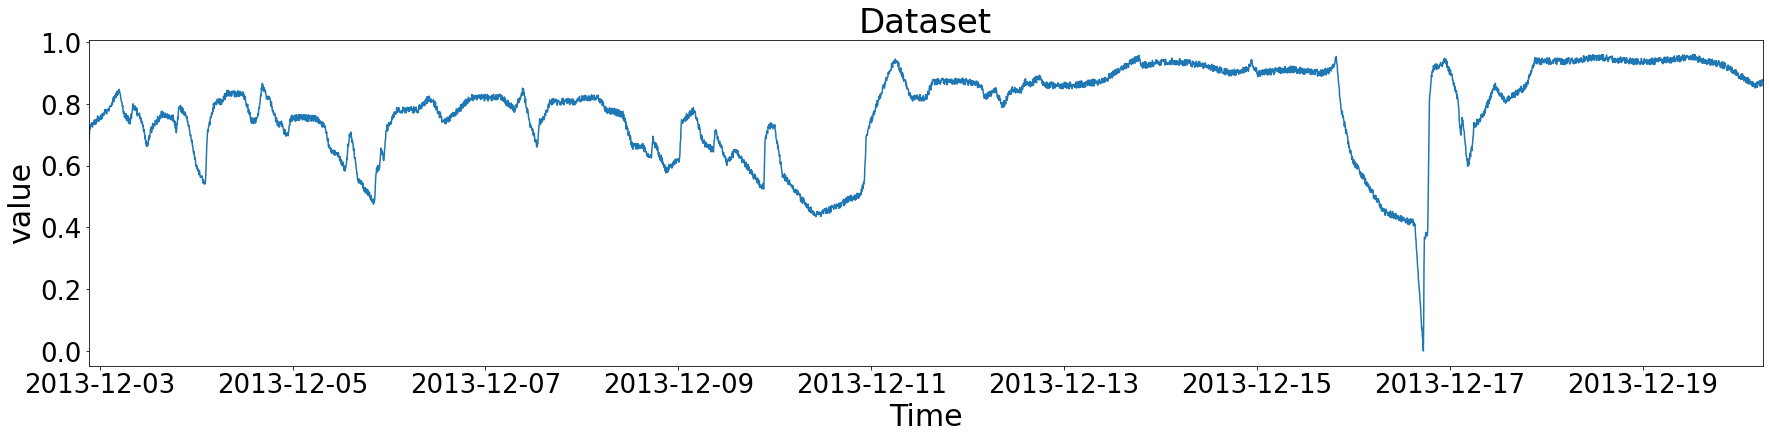

In [65]:
plot(temperature_data_train)

In [66]:
temperature_data_test = temperature_data[5000:7000]
print(temperature_data_test.head())
print(temperature_data_test.info())
temperature_data_test.to_csv('/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/temperature_test.csv', index=False)

       timestamp    signal  anomaly
5000  1387518900  0.872812        0
5001  1387519200  0.878082        0
5002  1387519500  0.879614        0
5003  1387519800  0.870780        0
5004  1387520100  0.880160        0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 5000 to 6999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  2000 non-null   int64  
 1   signal     2000 non-null   float64
 2   anomaly    2000 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 47.0 KB
None


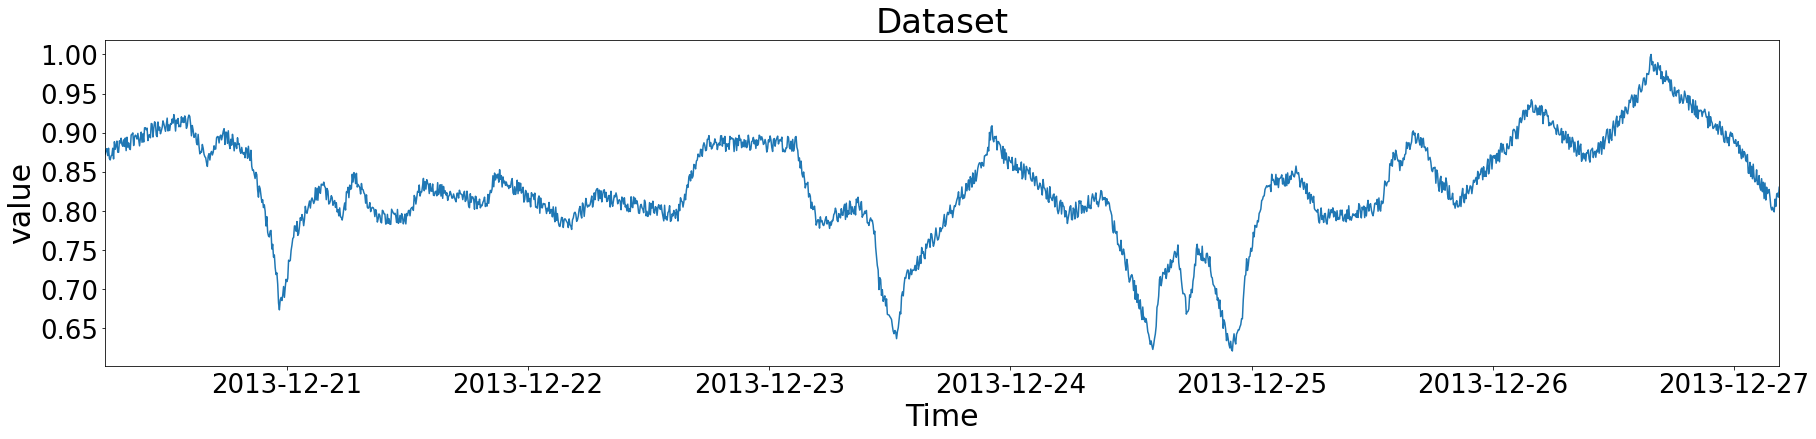

In [67]:
if isinstance(temperature_data_test, pd.DataFrame):
    dfs = [temperature_data_test]
        
df = dfs[0]
time = convert_date(df['timestamp'])


fig = plt.figure(figsize=(30, 6))
ax = fig.add_subplot(111)

for df in dfs:
    plt.plot(time, df['signal'])


plt.title('Dataset', size=34)
plt.ylabel('value', size=30)
plt.xlabel('Time', size=30)
plt.xticks(size=26)
plt.yticks(size=26)
plt.xlim([time[0], time[-1]])
    
plt.show()

In [68]:
train_dataset = SignalDataset(path=f'/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/temperature_train.csv')
test_dataset = SignalDataset(path=f'/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/temperature_test.csv')

In [69]:
def critic_x_iteration(sample):
    optim_cx.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    valid_x = critic_x(x)
    valid_x = torch.squeeze(valid_x)
    critic_score_valid_x = torch.mean(torch.ones(valid_x.shape) * valid_x)  # Wasserstein Loss

    # The sampled z are the anomalous points - points deviating from actual distribution of z (obtained through
    # encoding x)
    z = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    x_ = decoder(z)
    fake_x = critic_x(x_)
    fake_x = torch.squeeze(fake_x)
    critic_score_fake_x = torch.mean(torch.ones(fake_x.shape) * fake_x)  # Wasserstein Loss

    alpha = torch.rand(x.shape)
    ix = Variable(alpha * x + (1 - alpha) * x_)  # Random Weighted Average
    ix.requires_grad_(True)
    v_ix = critic_x(ix)
    v_ix.mean().backward()
    gradients = ix.grad
    # Gradient Penalty Loss
    gp_loss = torch.sqrt(torch.sum(torch.square(gradients).view(-1)))

    # Critic has to maximize Cx(Valid X) - Cx(Fake X).
    # Maximizing the above is same as minimizing the negative.
    wl = critic_score_fake_x - critic_score_valid_x
    loss = wl + gp_loss
    loss.backward()
    optim_cx.step()

    return loss

In [70]:
def critic_z_iteration(sample):
    optim_cz.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    z = encoder(x)
    valid_z = critic_z(z)
    valid_z = torch.squeeze(valid_z)
    critic_score_valid_z = torch.mean(torch.ones(valid_z.shape) * valid_z)

    z_ = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    fake_z = critic_z(z_)
    fake_z = torch.squeeze(fake_z)
    critic_score_fake_z = torch.mean(torch.ones(fake_z.shape) * fake_z)  # Wasserstein Loss

    wl = critic_score_fake_z - critic_score_valid_z

    alpha = torch.rand(z.shape)
    iz = Variable(alpha * z + (1 - alpha) * z_)  # Random Weighted Average
    iz.requires_grad_(True)
    v_iz = critic_z(iz)
    v_iz.mean().backward()
    gradients = iz.grad
    gp_loss = torch.sqrt(torch.sum(torch.square(gradients).view(-1)))

    loss = wl + gp_loss
    loss.backward()
    optim_cz.step()

    return loss

In [71]:
def encoder_iteration(sample):
    optim_enc.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    valid_x = critic_x(x)
    valid_x = torch.squeeze(valid_x)
    critic_score_valid_x = torch.mean(torch.ones(valid_x.shape) * valid_x)  # Wasserstein Loss

    z = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    x_ = decoder(z)
    fake_x = critic_x(x_)
    fake_x = torch.squeeze(fake_x)
    critic_score_fake_x = torch.mean(torch.ones(fake_x.shape) * fake_x)

    enc_z = encoder(x)
    gen_x = decoder(enc_z)

    mse = mse_loss(x.float(), gen_x.float())
    loss_enc = mse + critic_score_valid_x - critic_score_fake_x
    loss_enc.backward(retain_graph=True)
    optim_enc.step()

    return loss_enc

In [72]:
def decoder_iteration(sample):
    optim_dec.zero_grad()

    x = sample['signal'].view(1, batch_size, signal_shape)
    z = encoder(x)
    valid_z = critic_z(z)
    valid_z = torch.squeeze(valid_z)
    critic_score_valid_z = torch.mean(torch.ones(valid_z.shape) * valid_z)

    z_ = torch.empty(1, batch_size, latent_space_dim).uniform_(0, 1)
    fake_z = critic_z(z_)
    fake_z = torch.squeeze(fake_z)
    critic_score_fake_z = torch.mean(torch.ones(fake_z.shape) * fake_z)

    enc_z = encoder(x)
    gen_x = decoder(enc_z)

    mse = mse_loss(x.float(), gen_x.float())
    loss_dec = mse + critic_score_valid_z - critic_score_fake_z
    loss_dec.backward(retain_graph=True)
    optim_dec.step()

    return loss_dec

In [73]:
def train(n_epochs=100):
    cx_epoch_loss = list()
    cz_epoch_loss = list()
    encoder_epoch_loss = list()
    decoder_epoch_loss = list()

    for epoch in range(n_epochs):
        n_critics = 5

        cx_nc_loss = list()
        cz_nc_loss = list()

        for i in range(n_critics):
            cx_loss = list()
            cz_loss = list()

            for batch, sample in tqdm(enumerate(train_loader)):
                loss = critic_x_iteration(sample)
                cx_loss.append(loss)

                loss = critic_z_iteration(sample)
                cz_loss.append(loss)

            cx_nc_loss.append(torch.mean(torch.tensor(cx_loss)))
            cz_nc_loss.append(torch.mean(torch.tensor(cz_loss)))

        encoder_loss = list()
        decoder_loss = list()

        for batch, sample in tqdm(enumerate(train_loader)):
            enc_loss = encoder_iteration(sample)
            dec_loss = decoder_iteration(sample)
            encoder_loss.append(enc_loss)
            decoder_loss.append(dec_loss)

        cx_epoch_loss.append(torch.mean(torch.tensor(cx_nc_loss)))
        cz_epoch_loss.append(torch.mean(torch.tensor(cz_nc_loss)))
        encoder_epoch_loss.append(torch.mean(torch.tensor(encoder_loss)))
        decoder_epoch_loss.append(torch.mean(torch.tensor(decoder_loss)))
        print("epoch", epoch)
        print('critic x loss {:.3f} critic z loss {:.3f} encoder loss {:.3f} decoder loss {:.3f}\n'.format(
            cx_epoch_loss[-1], cz_epoch_loss[-1], encoder_epoch_loss[-1], decoder_epoch_loss[-1]))

In [95]:
def evaluate(test_loader):

    reconstructed_unroll = []

    for batch, sample in tqdm(enumerate(test_loader)):
        reconstructed_signal = decoder(encoder(sample['signal']))
        reconstructed_signal = torch.squeeze(reconstructed_signal)
        median_values, median_indices = torch.median(reconstructed_signal, 1)
        median_values_list = median_values.tolist()
        reconstructed_unroll.extend(median_values_list)
    return np.asarray(reconstructed_unroll)

In [75]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)

lr = 1e-6

signal_shape = 100
latent_space_dim = 20

encoder = model.Encoder(signal_shape)
decoder = model.Decoder(signal_shape)
critic_x = model.CriticX(signal_shape)
critic_z = model.CriticZ()

mse_loss = torch.nn.MSELoss()

optim_enc = optim.Adam(encoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_dec = optim.Adam(decoder.parameters(), lr=lr, betas=(0.5, 0.999))
optim_cx = optim.Adam(critic_x.parameters(), lr=lr, betas=(0.5, 0.999))
optim_cz = optim.Adam(critic_z.parameters(), lr=lr, betas=(0.5, 0.999))

train(n_epochs = 500)

76it [00:04, 17.46it/s]
76it [00:04, 17.56it/s]
76it [00:04, 17.69it/s]
76it [00:04, 17.06it/s]
76it [00:04, 17.26it/s]
76it [00:05, 15.20it/s]


epoch 0
critic x loss 0.294 critic z loss 0.167 encoder loss 0.407 decoder loss 0.542



76it [00:04, 17.39it/s]
76it [00:04, 17.08it/s]
76it [00:04, 17.58it/s]
76it [00:04, 16.67it/s]
76it [00:06, 11.67it/s]
76it [00:07, 10.13it/s]


epoch 1
critic x loss 0.235 critic z loss 0.167 encoder loss 0.466 decoder loss 0.543



76it [00:05, 14.73it/s]
76it [00:05, 14.00it/s]
76it [00:05, 15.15it/s]
76it [00:05, 13.97it/s]
76it [00:05, 13.56it/s]
76it [00:07, 10.45it/s]


epoch 2
critic x loss 0.176 critic z loss 0.165 encoder loss 0.524 decoder loss 0.542



76it [00:05, 12.72it/s]
76it [00:06, 11.58it/s]
76it [00:07, 10.09it/s]
76it [00:06, 11.22it/s]
76it [00:04, 16.72it/s]
76it [00:07, 10.73it/s]


epoch 3
critic x loss 0.118 critic z loss 0.162 encoder loss 0.582 decoder loss 0.548



76it [00:05, 13.98it/s]
76it [00:04, 17.44it/s]
76it [00:04, 17.79it/s]
76it [00:04, 16.56it/s]
76it [00:05, 14.23it/s]
76it [00:05, 13.21it/s]


epoch 4
critic x loss 0.059 critic z loss 0.162 encoder loss 0.640 decoder loss 0.549



76it [00:05, 14.40it/s]
76it [00:05, 13.57it/s]
76it [00:06, 12.66it/s]
76it [00:05, 12.91it/s]
76it [00:05, 12.84it/s]
76it [00:04, 15.73it/s]


epoch 5
critic x loss 0.001 critic z loss 0.159 encoder loss 0.698 decoder loss 0.548



76it [00:05, 14.27it/s]
76it [00:04, 18.08it/s]
76it [00:05, 14.28it/s]
76it [00:05, 13.77it/s]
76it [00:06, 11.31it/s]
76it [00:06, 12.19it/s]


epoch 6
critic x loss -0.058 critic z loss 0.158 encoder loss 0.756 decoder loss 0.544



76it [00:05, 13.77it/s]
76it [00:05, 14.02it/s]
76it [00:05, 14.00it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.79it/s]
76it [00:06, 11.05it/s]


epoch 7
critic x loss -0.116 critic z loss 0.155 encoder loss 0.814 decoder loss 0.549



76it [00:06, 11.55it/s]
76it [00:07, 10.61it/s]
76it [00:04, 17.28it/s]
76it [00:07, 10.51it/s]
76it [00:05, 14.44it/s]
76it [00:05, 13.19it/s]


epoch 8
critic x loss -0.175 critic z loss 0.153 encoder loss 0.873 decoder loss 0.554



76it [00:04, 18.44it/s]
76it [00:04, 18.08it/s]
76it [00:04, 18.28it/s]
76it [00:04, 18.22it/s]
76it [00:04, 17.96it/s]
76it [00:04, 15.71it/s]


epoch 9
critic x loss -0.234 critic z loss 0.152 encoder loss 0.931 decoder loss 0.557



76it [00:04, 18.59it/s]
76it [00:04, 18.16it/s]
76it [00:04, 17.59it/s]
76it [00:04, 18.27it/s]
76it [00:04, 18.28it/s]
76it [00:04, 15.43it/s]


epoch 10
critic x loss -0.293 critic z loss 0.149 encoder loss 0.990 decoder loss 0.554



76it [00:04, 17.20it/s]
76it [00:04, 17.48it/s]
76it [00:04, 17.96it/s]
76it [00:04, 18.09it/s]
76it [00:04, 16.32it/s]
76it [00:04, 15.25it/s]


epoch 11
critic x loss -0.352 critic z loss 0.147 encoder loss 1.049 decoder loss 0.560



76it [00:04, 17.99it/s]
76it [00:04, 17.61it/s]
76it [00:04, 17.90it/s]
76it [00:04, 17.73it/s]
76it [00:04, 18.14it/s]
76it [00:04, 15.45it/s]


epoch 12
critic x loss -0.412 critic z loss 0.148 encoder loss 1.108 decoder loss 0.555



76it [00:04, 18.03it/s]
76it [00:04, 18.38it/s]
76it [00:04, 18.03it/s]
76it [00:04, 18.24it/s]
76it [00:04, 18.34it/s]
76it [00:04, 15.75it/s]


epoch 13
critic x loss -0.471 critic z loss 0.144 encoder loss 1.167 decoder loss 0.565



76it [00:04, 18.15it/s]
76it [00:04, 18.76it/s]
76it [00:04, 17.97it/s]
76it [00:04, 18.35it/s]
76it [00:04, 17.66it/s]
76it [00:04, 15.69it/s]


epoch 14
critic x loss -0.531 critic z loss 0.141 encoder loss 1.227 decoder loss 0.560



76it [00:04, 18.37it/s]
76it [00:04, 18.38it/s]
76it [00:04, 17.98it/s]
76it [00:04, 18.28it/s]
76it [00:04, 16.27it/s]
76it [00:04, 15.41it/s]


epoch 15
critic x loss -0.591 critic z loss 0.139 encoder loss 1.287 decoder loss 0.562



76it [00:04, 18.45it/s]
76it [00:04, 18.26it/s]
76it [00:04, 18.00it/s]
76it [00:04, 18.19it/s]
76it [00:04, 18.27it/s]
76it [00:04, 15.49it/s]


epoch 16
critic x loss -0.652 critic z loss 0.138 encoder loss 1.348 decoder loss 0.558



76it [00:04, 17.70it/s]
76it [00:04, 17.29it/s]
76it [00:04, 18.41it/s]
76it [00:04, 18.11it/s]
76it [00:06, 11.61it/s]
76it [00:09,  7.84it/s]


epoch 17
critic x loss -0.712 critic z loss 0.138 encoder loss 1.408 decoder loss 0.566



76it [00:05, 12.83it/s]
76it [00:06, 12.18it/s]
76it [00:05, 13.85it/s]
76it [00:06, 12.33it/s]
76it [00:04, 18.36it/s]
76it [00:04, 15.51it/s]


epoch 18
critic x loss -0.773 critic z loss 0.134 encoder loss 1.469 decoder loss 0.565



76it [00:04, 18.28it/s]
76it [00:04, 17.50it/s]
76it [00:05, 14.80it/s]
76it [00:04, 18.03it/s]
76it [00:04, 18.11it/s]
76it [00:04, 15.49it/s]


epoch 19
critic x loss -0.835 critic z loss 0.132 encoder loss 1.531 decoder loss 0.569



76it [00:04, 17.96it/s]
76it [00:04, 18.00it/s]
76it [00:04, 17.76it/s]
76it [00:04, 17.87it/s]
76it [00:04, 17.66it/s]
76it [00:04, 15.45it/s]


epoch 20
critic x loss -0.896 critic z loss 0.130 encoder loss 1.592 decoder loss 0.569



76it [00:04, 18.11it/s]
76it [00:04, 18.09it/s]
76it [00:04, 18.11it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.66it/s]
76it [00:04, 15.44it/s]


epoch 21
critic x loss -0.958 critic z loss 0.126 encoder loss 1.655 decoder loss 0.573



76it [00:04, 18.09it/s]
76it [00:04, 17.90it/s]
76it [00:04, 18.02it/s]
76it [00:04, 18.31it/s]
76it [00:04, 17.93it/s]
76it [00:04, 15.45it/s]


epoch 22
critic x loss -1.021 critic z loss 0.126 encoder loss 1.717 decoder loss 0.574



76it [00:04, 17.89it/s]
76it [00:04, 17.93it/s]
76it [00:04, 17.86it/s]
76it [00:04, 17.94it/s]
76it [00:04, 18.06it/s]
76it [00:04, 15.65it/s]


epoch 23
critic x loss -1.083 critic z loss 0.122 encoder loss 1.780 decoder loss 0.575



76it [00:04, 17.91it/s]
76it [00:04, 17.78it/s]
76it [00:04, 18.14it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.41it/s]
76it [00:04, 15.45it/s]


epoch 24
critic x loss -1.146 critic z loss 0.119 encoder loss 1.843 decoder loss 0.577



76it [00:04, 17.90it/s]
76it [00:04, 16.13it/s]
76it [00:06, 11.88it/s]
76it [00:04, 16.73it/s]
76it [00:04, 17.57it/s]
76it [00:04, 15.29it/s]


epoch 25
critic x loss -1.210 critic z loss 0.118 encoder loss 1.907 decoder loss 0.581



76it [00:04, 18.11it/s]
76it [00:04, 17.50it/s]
76it [00:04, 15.34it/s]
76it [00:04, 16.63it/s]
76it [00:07, 10.37it/s]
76it [00:10,  7.46it/s]


epoch 26
critic x loss -1.274 critic z loss 0.113 encoder loss 1.971 decoder loss 0.578



76it [00:06, 11.68it/s]
76it [00:04, 17.05it/s]
76it [00:04, 16.05it/s]
76it [00:05, 13.04it/s]
76it [00:07, 10.09it/s]
76it [00:05, 15.04it/s]


epoch 27
critic x loss -1.338 critic z loss 0.111 encoder loss 2.036 decoder loss 0.584



76it [00:04, 16.92it/s]
76it [00:05, 14.29it/s]
76it [00:06, 12.65it/s]
76it [00:05, 12.71it/s]
76it [00:07,  9.67it/s]
76it [00:05, 12.85it/s]


epoch 28
critic x loss -1.403 critic z loss 0.109 encoder loss 2.101 decoder loss 0.587



76it [00:04, 18.21it/s]
76it [00:04, 17.83it/s]
76it [00:04, 17.07it/s]
76it [00:05, 15.03it/s]
76it [00:06, 11.63it/s]
76it [00:05, 13.79it/s]


epoch 29
critic x loss -1.468 critic z loss 0.109 encoder loss 2.166 decoder loss 0.588



76it [00:04, 17.51it/s]
76it [00:04, 17.30it/s]
76it [00:05, 12.75it/s]
76it [00:05, 13.57it/s]
76it [00:04, 16.46it/s]
76it [00:07, 10.15it/s]


epoch 30
critic x loss -1.533 critic z loss 0.106 encoder loss 2.232 decoder loss 0.589



76it [00:05, 14.10it/s]
76it [00:05, 12.89it/s]
76it [00:07, 10.74it/s]
76it [00:06, 12.30it/s]
76it [00:10,  7.26it/s]
76it [00:09,  8.08it/s]


epoch 31
critic x loss -1.599 critic z loss 0.103 encoder loss 2.298 decoder loss 0.592



76it [00:05, 12.97it/s]
76it [00:05, 13.68it/s]
76it [00:05, 14.82it/s]
76it [00:04, 18.06it/s]
76it [00:04, 18.00it/s]
76it [00:04, 15.59it/s]


epoch 32
critic x loss -1.665 critic z loss 0.099 encoder loss 2.365 decoder loss 0.592



76it [00:04, 18.05it/s]
76it [00:04, 17.69it/s]
76it [00:04, 17.81it/s]
76it [00:04, 17.91it/s]
76it [00:04, 17.88it/s]
76it [00:04, 15.53it/s]


epoch 33
critic x loss -1.732 critic z loss 0.097 encoder loss 2.432 decoder loss 0.594



76it [00:04, 18.17it/s]
76it [00:04, 17.97it/s]
76it [00:04, 17.86it/s]
76it [00:04, 17.31it/s]
76it [00:04, 18.09it/s]
76it [00:04, 15.65it/s]


epoch 34
critic x loss -1.799 critic z loss 0.092 encoder loss 2.499 decoder loss 0.601



76it [00:04, 18.16it/s]
76it [00:04, 18.11it/s]
76it [00:04, 18.06it/s]
76it [00:04, 18.16it/s]
76it [00:04, 15.66it/s]
76it [00:04, 15.52it/s]


epoch 35
critic x loss -1.866 critic z loss 0.090 encoder loss 2.567 decoder loss 0.604



76it [00:04, 17.70it/s]
76it [00:04, 18.25it/s]
76it [00:04, 17.84it/s]
76it [00:04, 18.14it/s]
76it [00:04, 17.92it/s]
76it [00:04, 15.32it/s]


epoch 36
critic x loss -1.934 critic z loss 0.088 encoder loss 2.635 decoder loss 0.607



76it [00:04, 15.81it/s]
76it [00:04, 17.59it/s]
76it [00:04, 17.89it/s]
76it [00:04, 18.00it/s]
76it [00:04, 18.06it/s]
76it [00:04, 15.24it/s]


epoch 37
critic x loss -2.002 critic z loss 0.084 encoder loss 2.703 decoder loss 0.608



76it [00:04, 17.79it/s]
76it [00:04, 17.54it/s]
76it [00:04, 17.83it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.76it/s]
76it [00:04, 15.39it/s]


epoch 38
critic x loss -2.071 critic z loss 0.079 encoder loss 2.772 decoder loss 0.604



76it [00:04, 18.00it/s]
76it [00:04, 17.69it/s]
76it [00:04, 17.32it/s]
76it [00:04, 17.70it/s]
76it [00:04, 17.53it/s]
76it [00:04, 15.49it/s]


epoch 39
critic x loss -2.140 critic z loss 0.077 encoder loss 2.842 decoder loss 0.610



76it [00:04, 18.08it/s]
76it [00:04, 18.09it/s]
76it [00:04, 17.32it/s]
76it [00:04, 17.44it/s]
76it [00:04, 17.22it/s]
76it [00:04, 15.57it/s]


epoch 40
critic x loss -2.209 critic z loss 0.075 encoder loss 2.911 decoder loss 0.611



76it [00:04, 17.93it/s]
76it [00:04, 18.06it/s]
76it [00:04, 17.93it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.74it/s]
76it [00:04, 15.21it/s]


epoch 41
critic x loss -2.278 critic z loss 0.071 encoder loss 2.981 decoder loss 0.615



76it [00:04, 18.23it/s]
76it [00:04, 18.22it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.85it/s]
76it [00:04, 17.69it/s]
76it [00:04, 15.45it/s]


epoch 42
critic x loss -2.348 critic z loss 0.068 encoder loss 3.051 decoder loss 0.622



76it [00:04, 17.93it/s]
76it [00:04, 17.83it/s]
76it [00:04, 17.63it/s]
76it [00:04, 18.01it/s]
76it [00:04, 17.77it/s]
76it [00:04, 15.46it/s]


epoch 43
critic x loss -2.419 critic z loss 0.067 encoder loss 3.122 decoder loss 0.622



76it [00:04, 17.72it/s]
76it [00:04, 18.09it/s]
76it [00:04, 18.00it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.92it/s]
76it [00:04, 15.45it/s]


epoch 44
critic x loss -2.489 critic z loss 0.060 encoder loss 3.193 decoder loss 0.622



76it [00:04, 17.96it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.85it/s]
76it [00:04, 15.29it/s]


epoch 45
critic x loss -2.560 critic z loss 0.057 encoder loss 3.265 decoder loss 0.629



76it [00:04, 18.04it/s]
76it [00:04, 17.39it/s]
76it [00:04, 17.77it/s]
76it [00:04, 18.20it/s]
76it [00:04, 17.67it/s]
76it [00:05, 15.16it/s]


epoch 46
critic x loss -2.631 critic z loss 0.052 encoder loss 3.336 decoder loss 0.632



76it [00:04, 17.68it/s]
76it [00:04, 17.85it/s]
76it [00:04, 17.54it/s]
76it [00:04, 18.07it/s]
76it [00:04, 17.90it/s]
76it [00:04, 15.30it/s]


epoch 47
critic x loss -2.703 critic z loss 0.049 encoder loss 3.409 decoder loss 0.633



76it [00:04, 17.64it/s]
76it [00:04, 17.71it/s]
76it [00:04, 17.63it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.76it/s]
76it [00:04, 15.44it/s]


epoch 48
critic x loss -2.775 critic z loss 0.048 encoder loss 3.481 decoder loss 0.635



76it [00:04, 18.05it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.75it/s]
76it [00:04, 17.85it/s]
76it [00:04, 17.92it/s]
76it [00:04, 15.38it/s]


epoch 49
critic x loss -2.848 critic z loss 0.046 encoder loss 3.554 decoder loss 0.643



76it [00:04, 17.97it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.94it/s]
76it [00:04, 18.10it/s]
76it [00:04, 17.49it/s]
76it [00:04, 15.67it/s]


epoch 50
critic x loss -2.920 critic z loss 0.040 encoder loss 3.627 decoder loss 0.645



76it [00:04, 17.88it/s]
76it [00:04, 18.18it/s]
76it [00:04, 17.96it/s]
76it [00:04, 18.01it/s]
76it [00:04, 18.30it/s]
76it [00:04, 15.57it/s]


epoch 51
critic x loss -2.993 critic z loss 0.038 encoder loss 3.701 decoder loss 0.643



76it [00:04, 17.95it/s]
76it [00:04, 17.55it/s]
76it [00:04, 18.09it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.95it/s]
76it [00:04, 15.50it/s]


epoch 52
critic x loss -3.067 critic z loss 0.033 encoder loss 3.774 decoder loss 0.647



76it [00:04, 18.23it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.95it/s]
76it [00:04, 18.00it/s]
76it [00:04, 18.11it/s]
76it [00:04, 15.50it/s]


epoch 53
critic x loss -3.140 critic z loss 0.029 encoder loss 3.849 decoder loss 0.651



76it [00:04, 18.20it/s]
76it [00:04, 18.06it/s]
76it [00:04, 17.53it/s]
76it [00:04, 18.08it/s]
76it [00:04, 17.93it/s]
76it [00:04, 15.54it/s]


epoch 54
critic x loss -3.214 critic z loss 0.028 encoder loss 3.923 decoder loss 0.650



76it [00:04, 18.05it/s]
76it [00:04, 18.10it/s]
76it [00:04, 18.26it/s]
76it [00:04, 18.19it/s]
76it [00:04, 17.69it/s]
76it [00:04, 15.39it/s]


epoch 55
critic x loss -3.289 critic z loss 0.026 encoder loss 3.998 decoder loss 0.657



76it [00:04, 17.85it/s]
76it [00:04, 17.86it/s]
76it [00:04, 18.03it/s]
76it [00:04, 18.13it/s]
76it [00:04, 18.20it/s]
76it [00:04, 15.35it/s]


epoch 56
critic x loss -3.364 critic z loss 0.020 encoder loss 4.074 decoder loss 0.659



76it [00:04, 17.94it/s]
76it [00:04, 18.21it/s]
76it [00:04, 18.00it/s]
76it [00:04, 17.96it/s]
76it [00:04, 18.53it/s]
76it [00:04, 15.88it/s]


epoch 57
critic x loss -3.439 critic z loss 0.018 encoder loss 4.149 decoder loss 0.657



76it [00:04, 18.20it/s]
76it [00:04, 17.78it/s]
76it [00:04, 18.01it/s]
76it [00:04, 18.01it/s]
76it [00:04, 18.04it/s]
76it [00:04, 15.74it/s]


epoch 58
critic x loss -3.514 critic z loss 0.014 encoder loss 4.225 decoder loss 0.665



76it [00:04, 17.83it/s]
76it [00:04, 17.58it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.17it/s]
76it [00:04, 18.45it/s]
76it [00:04, 15.61it/s]


epoch 59
critic x loss -3.590 critic z loss 0.011 encoder loss 4.301 decoder loss 0.660



76it [00:04, 18.35it/s]
76it [00:04, 18.17it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.07it/s]
76it [00:04, 17.81it/s]
76it [00:04, 15.63it/s]


epoch 60
critic x loss -3.666 critic z loss 0.008 encoder loss 4.378 decoder loss 0.666



76it [00:04, 18.06it/s]
76it [00:04, 18.24it/s]
76it [00:04, 17.95it/s]
76it [00:04, 17.79it/s]
76it [00:04, 18.43it/s]
76it [00:04, 15.65it/s]


epoch 61
critic x loss -3.742 critic z loss 0.006 encoder loss 4.455 decoder loss 0.667



76it [00:04, 18.01it/s]
76it [00:04, 17.84it/s]
76it [00:04, 18.10it/s]
76it [00:04, 17.93it/s]
76it [00:04, 18.16it/s]
76it [00:04, 15.90it/s]


epoch 62
critic x loss -3.819 critic z loss 0.001 encoder loss 4.532 decoder loss 0.671



76it [00:04, 18.13it/s]
76it [00:04, 18.15it/s]
76it [00:04, 17.92it/s]
76it [00:04, 18.30it/s]
76it [00:04, 18.19it/s]
76it [00:04, 15.72it/s]


epoch 63
critic x loss -3.896 critic z loss -0.002 encoder loss 4.609 decoder loss 0.677



76it [00:04, 17.68it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.71it/s]
76it [00:04, 18.31it/s]
76it [00:04, 15.67it/s]


epoch 64
critic x loss -3.973 critic z loss -0.007 encoder loss 4.687 decoder loss 0.674



76it [00:04, 18.12it/s]
76it [00:04, 17.79it/s]
76it [00:04, 18.03it/s]
76it [00:04, 18.23it/s]
76it [00:04, 18.10it/s]
76it [00:04, 15.70it/s]


epoch 65
critic x loss -4.051 critic z loss -0.007 encoder loss 4.766 decoder loss 0.678



76it [00:04, 18.13it/s]
76it [00:04, 17.79it/s]
76it [00:04, 18.27it/s]
76it [00:04, 17.97it/s]
76it [00:04, 18.13it/s]
76it [00:04, 15.61it/s]


epoch 66
critic x loss -4.129 critic z loss -0.012 encoder loss 4.844 decoder loss 0.675



76it [00:04, 17.84it/s]
76it [00:04, 17.99it/s]
76it [00:04, 18.19it/s]
76it [00:04, 18.41it/s]
76it [00:04, 18.19it/s]
76it [00:04, 15.64it/s]


epoch 67
critic x loss -4.207 critic z loss -0.015 encoder loss 4.923 decoder loss 0.678



76it [00:04, 18.37it/s]
76it [00:04, 18.48it/s]
76it [00:04, 17.51it/s]
76it [00:04, 18.14it/s]
76it [00:04, 17.98it/s]
76it [00:04, 15.49it/s]


epoch 68
critic x loss -4.286 critic z loss -0.016 encoder loss 5.002 decoder loss 0.686



76it [00:04, 18.28it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.99it/s]
76it [00:04, 17.97it/s]
76it [00:04, 15.80it/s]


epoch 69
critic x loss -4.365 critic z loss -0.019 encoder loss 5.082 decoder loss 0.689



76it [00:04, 18.03it/s]
76it [00:04, 18.15it/s]
76it [00:04, 18.28it/s]
76it [00:04, 18.19it/s]
76it [00:04, 18.02it/s]
76it [00:04, 15.43it/s]


epoch 70
critic x loss -4.444 critic z loss -0.023 encoder loss 5.161 decoder loss 0.686



76it [00:04, 18.12it/s]
76it [00:04, 17.93it/s]
76it [00:04, 18.06it/s]
76it [00:04, 18.07it/s]
76it [00:04, 18.22it/s]
76it [00:04, 15.73it/s]


epoch 71
critic x loss -4.524 critic z loss -0.025 encoder loss 5.242 decoder loss 0.691



76it [00:04, 17.96it/s]
76it [00:04, 18.13it/s]
76it [00:04, 18.42it/s]
76it [00:04, 17.64it/s]
76it [00:04, 18.06it/s]
76it [00:04, 15.60it/s]


epoch 72
critic x loss -4.604 critic z loss -0.029 encoder loss 5.322 decoder loss 0.696



76it [00:04, 18.16it/s]
76it [00:04, 18.20it/s]
76it [00:04, 18.19it/s]
76it [00:04, 18.02it/s]
76it [00:04, 18.31it/s]
76it [00:04, 15.57it/s]


epoch 73
critic x loss -4.684 critic z loss -0.033 encoder loss 5.403 decoder loss 0.697



76it [00:04, 17.95it/s]
76it [00:04, 18.29it/s]
76it [00:04, 18.21it/s]
76it [00:04, 18.14it/s]
76it [00:04, 17.70it/s]
76it [00:04, 15.79it/s]


epoch 74
critic x loss -4.765 critic z loss -0.036 encoder loss 5.484 decoder loss 0.697



76it [00:04, 18.29it/s]
76it [00:04, 18.40it/s]
76it [00:04, 18.20it/s]
76it [00:04, 18.23it/s]
76it [00:04, 18.46it/s]
76it [00:04, 15.71it/s]


epoch 75
critic x loss -4.845 critic z loss -0.038 encoder loss 5.565 decoder loss 0.695



76it [00:04, 17.64it/s]
76it [00:04, 17.74it/s]
76it [00:04, 18.07it/s]
76it [00:04, 18.22it/s]
76it [00:04, 18.35it/s]
76it [00:04, 15.77it/s]


epoch 76
critic x loss -4.926 critic z loss -0.041 encoder loss 5.647 decoder loss 0.702



76it [00:04, 18.35it/s]
76it [00:04, 17.78it/s]
76it [00:04, 18.17it/s]
76it [00:04, 18.22it/s]
76it [00:04, 17.72it/s]
76it [00:04, 15.73it/s]


epoch 77
critic x loss -5.008 critic z loss -0.045 encoder loss 5.728 decoder loss 0.705



76it [00:04, 18.08it/s]
76it [00:04, 18.23it/s]
76it [00:04, 18.28it/s]
76it [00:04, 17.75it/s]
76it [00:04, 18.47it/s]
76it [00:04, 15.89it/s]


epoch 78
critic x loss -5.090 critic z loss -0.047 encoder loss 5.811 decoder loss 0.703



76it [00:04, 18.35it/s]
76it [00:04, 18.06it/s]
76it [00:04, 18.21it/s]
76it [00:04, 18.07it/s]
76it [00:04, 18.33it/s]
76it [00:04, 15.71it/s]


epoch 79
critic x loss -5.172 critic z loss -0.051 encoder loss 5.893 decoder loss 0.706



76it [00:04, 17.61it/s]
76it [00:04, 18.25it/s]
76it [00:04, 18.35it/s]
76it [00:04, 18.43it/s]
76it [00:04, 18.21it/s]
76it [00:04, 15.38it/s]


epoch 80
critic x loss -5.254 critic z loss -0.051 encoder loss 5.976 decoder loss 0.710



76it [00:04, 18.11it/s]
76it [00:04, 18.03it/s]
76it [00:04, 18.30it/s]
76it [00:04, 18.43it/s]
76it [00:04, 18.06it/s]
76it [00:04, 15.81it/s]


epoch 81
critic x loss -5.337 critic z loss -0.057 encoder loss 6.059 decoder loss 0.708



76it [00:04, 18.28it/s]
76it [00:04, 18.08it/s]
76it [00:04, 17.75it/s]
76it [00:04, 18.15it/s]
76it [00:04, 18.06it/s]
76it [00:04, 15.49it/s]


epoch 82
critic x loss -5.420 critic z loss -0.056 encoder loss 6.142 decoder loss 0.716



76it [00:04, 18.11it/s]
76it [00:04, 18.61it/s]
76it [00:04, 18.01it/s]
76it [00:04, 18.53it/s]
76it [00:04, 17.87it/s]
76it [00:04, 15.91it/s]


epoch 83
critic x loss -5.503 critic z loss -0.060 encoder loss 6.226 decoder loss 0.714



76it [00:04, 18.22it/s]
76it [00:04, 18.33it/s]
76it [00:04, 18.22it/s]
76it [00:04, 17.97it/s]
76it [00:04, 17.61it/s]
76it [00:04, 15.51it/s]


epoch 84
critic x loss -5.586 critic z loss -0.064 encoder loss 6.310 decoder loss 0.718



76it [00:04, 18.00it/s]
76it [00:04, 18.08it/s]
76it [00:04, 17.78it/s]
76it [00:04, 18.13it/s]
76it [00:04, 18.19it/s]
76it [00:04, 15.69it/s]


epoch 85
critic x loss -5.670 critic z loss -0.065 encoder loss 6.394 decoder loss 0.720



76it [00:04, 18.26it/s]
76it [00:04, 17.60it/s]
76it [00:04, 18.01it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.96it/s]
76it [00:04, 15.62it/s]


epoch 86
critic x loss -5.754 critic z loss -0.069 encoder loss 6.478 decoder loss 0.725



76it [00:04, 17.70it/s]
76it [00:04, 18.12it/s]
76it [00:04, 17.97it/s]
76it [00:04, 18.16it/s]
76it [00:04, 18.40it/s]
76it [00:04, 15.64it/s]


epoch 87
critic x loss -5.839 critic z loss -0.072 encoder loss 6.564 decoder loss 0.719



76it [00:04, 17.80it/s]
76it [00:04, 17.65it/s]
76it [00:04, 18.16it/s]
76it [00:04, 18.00it/s]
76it [00:04, 17.99it/s]
76it [00:04, 15.48it/s]


epoch 88
critic x loss -5.923 critic z loss -0.076 encoder loss 6.648 decoder loss 0.720



76it [00:04, 18.32it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.71it/s]
76it [00:04, 18.15it/s]
76it [00:04, 17.95it/s]
76it [00:04, 15.65it/s]


epoch 89
critic x loss -6.008 critic z loss -0.079 encoder loss 6.734 decoder loss 0.720



76it [00:04, 17.69it/s]
76it [00:04, 17.95it/s]
76it [00:04, 17.74it/s]
76it [00:04, 18.01it/s]
76it [00:04, 18.24it/s]
76it [00:04, 15.71it/s]


epoch 90
critic x loss -6.094 critic z loss -0.082 encoder loss 6.820 decoder loss 0.727



76it [00:04, 18.39it/s]
76it [00:04, 17.77it/s]
76it [00:04, 18.44it/s]
76it [00:04, 18.23it/s]
76it [00:04, 17.77it/s]
76it [00:04, 15.96it/s]


epoch 91
critic x loss -6.179 critic z loss -0.084 encoder loss 6.906 decoder loss 0.725



76it [00:04, 18.12it/s]
76it [00:04, 18.24it/s]
76it [00:04, 18.16it/s]
76it [00:04, 17.38it/s]
76it [00:04, 17.97it/s]
76it [00:04, 15.50it/s]


epoch 92
critic x loss -6.265 critic z loss -0.088 encoder loss 6.992 decoder loss 0.728



76it [00:04, 18.25it/s]
76it [00:04, 18.20it/s]
76it [00:04, 17.93it/s]
76it [00:04, 18.16it/s]
76it [00:04, 18.29it/s]
76it [00:04, 15.74it/s]


epoch 93
critic x loss -6.351 critic z loss -0.090 encoder loss 7.078 decoder loss 0.733



76it [00:04, 17.92it/s]
76it [00:04, 18.59it/s]
76it [00:04, 18.12it/s]
76it [00:04, 18.38it/s]
76it [00:04, 18.56it/s]
76it [00:04, 15.83it/s]


epoch 94
critic x loss -6.437 critic z loss -0.094 encoder loss 7.165 decoder loss 0.730



76it [00:04, 18.19it/s]
76it [00:04, 17.64it/s]
76it [00:04, 18.19it/s]
76it [00:04, 18.41it/s]
76it [00:04, 17.98it/s]
76it [00:04, 15.78it/s]


epoch 95
critic x loss -6.524 critic z loss -0.095 encoder loss 7.252 decoder loss 0.738



76it [00:04, 18.20it/s]
76it [00:04, 18.01it/s]
76it [00:04, 17.55it/s]
76it [00:04, 18.18it/s]
76it [00:04, 18.41it/s]
76it [00:04, 15.85it/s]


epoch 96
critic x loss -6.611 critic z loss -0.100 encoder loss 7.338 decoder loss 0.738



76it [00:04, 18.39it/s]
76it [00:04, 18.28it/s]
76it [00:04, 18.29it/s]
76it [00:04, 18.29it/s]
76it [00:04, 18.21it/s]
76it [00:04, 15.65it/s]


epoch 97
critic x loss -6.698 critic z loss -0.101 encoder loss 7.426 decoder loss 0.736



76it [00:04, 18.29it/s]
76it [00:04, 18.24it/s]
76it [00:04, 18.26it/s]
76it [00:04, 17.98it/s]
76it [00:04, 17.93it/s]
76it [00:04, 15.43it/s]


epoch 98
critic x loss -6.785 critic z loss -0.103 encoder loss 7.514 decoder loss 0.738



76it [00:04, 18.19it/s]
76it [00:04, 18.37it/s]
76it [00:04, 18.26it/s]
76it [00:04, 17.94it/s]
76it [00:04, 18.38it/s]
76it [00:04, 15.30it/s]


epoch 99
critic x loss -6.873 critic z loss -0.108 encoder loss 7.602 decoder loss 0.743



76it [00:04, 17.64it/s]
76it [00:04, 17.66it/s]
76it [00:04, 18.46it/s]
76it [00:04, 18.48it/s]
76it [00:04, 18.19it/s]
76it [00:04, 15.61it/s]


epoch 100
critic x loss -6.961 critic z loss -0.111 encoder loss 7.690 decoder loss 0.744



76it [00:04, 18.26it/s]
76it [00:04, 18.29it/s]
76it [00:04, 18.20it/s]
76it [00:04, 17.94it/s]
76it [00:04, 18.34it/s]
76it [00:04, 15.89it/s]


epoch 101
critic x loss -7.049 critic z loss -0.114 encoder loss 7.779 decoder loss 0.748



76it [00:04, 18.11it/s]
76it [00:04, 18.31it/s]
76it [00:04, 18.62it/s]
76it [00:04, 17.87it/s]
76it [00:04, 17.64it/s]
76it [00:04, 15.56it/s]


epoch 102
critic x loss -7.138 critic z loss -0.117 encoder loss 7.867 decoder loss 0.748



76it [00:04, 18.17it/s]
76it [00:04, 18.05it/s]
76it [00:04, 18.29it/s]
76it [00:04, 18.29it/s]
76it [00:04, 18.56it/s]
76it [00:04, 15.93it/s]


epoch 103
critic x loss -7.226 critic z loss -0.119 encoder loss 7.957 decoder loss 0.753



76it [00:04, 17.91it/s]
76it [00:04, 18.23it/s]
76it [00:04, 18.04it/s]
76it [00:04, 18.58it/s]
76it [00:04, 18.23it/s]
76it [00:04, 15.94it/s]


epoch 104
critic x loss -7.315 critic z loss -0.123 encoder loss 8.045 decoder loss 0.747



76it [00:04, 18.45it/s]
76it [00:04, 17.76it/s]
76it [00:04, 18.24it/s]
76it [00:04, 18.03it/s]
76it [00:04, 17.88it/s]
76it [00:04, 15.77it/s]


epoch 105
critic x loss -7.404 critic z loss -0.128 encoder loss 8.135 decoder loss 0.751



76it [00:04, 18.11it/s]
76it [00:04, 18.00it/s]
76it [00:04, 18.58it/s]
76it [00:04, 18.11it/s]
76it [00:04, 17.83it/s]
76it [00:04, 16.06it/s]


epoch 106
critic x loss -7.494 critic z loss -0.129 encoder loss 8.224 decoder loss 0.756



76it [00:04, 18.27it/s]
76it [00:04, 18.52it/s]
76it [00:04, 18.00it/s]
76it [00:04, 18.23it/s]
76it [00:04, 18.39it/s]
76it [00:04, 15.41it/s]


epoch 107
critic x loss -7.584 critic z loss -0.132 encoder loss 8.314 decoder loss 0.753



76it [00:04, 18.36it/s]
76it [00:04, 18.17it/s]
76it [00:04, 18.29it/s]
76it [00:04, 18.63it/s]
76it [00:04, 17.93it/s]
76it [00:04, 15.69it/s]


epoch 108
critic x loss -7.674 critic z loss -0.136 encoder loss 8.404 decoder loss 0.758



76it [00:04, 18.35it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.27it/s]
76it [00:04, 18.38it/s]
76it [00:04, 18.58it/s]
76it [00:04, 15.70it/s]


epoch 109
critic x loss -7.763 critic z loss -0.138 encoder loss 8.494 decoder loss 0.758



76it [00:04, 17.97it/s]
76it [00:04, 18.61it/s]
76it [00:04, 17.95it/s]
76it [00:04, 17.84it/s]
76it [00:04, 18.12it/s]
76it [00:04, 15.78it/s]


epoch 110
critic x loss -7.854 critic z loss -0.140 encoder loss 8.585 decoder loss 0.761



76it [00:04, 18.25it/s]
76it [00:04, 18.45it/s]
76it [00:04, 17.95it/s]
76it [00:04, 18.14it/s]
76it [00:04, 17.83it/s]
76it [00:04, 15.63it/s]


epoch 111
critic x loss -7.944 critic z loss -0.143 encoder loss 8.675 decoder loss 0.762



76it [00:04, 17.40it/s]
76it [00:04, 17.99it/s]
76it [00:04, 18.16it/s]
76it [00:04, 18.03it/s]
76it [00:04, 18.01it/s]
76it [00:04, 15.55it/s]


epoch 112
critic x loss -8.035 critic z loss -0.148 encoder loss 8.767 decoder loss 0.763



76it [00:04, 18.38it/s]
76it [00:04, 18.05it/s]
76it [00:04, 18.23it/s]
76it [00:04, 18.37it/s]
76it [00:04, 18.12it/s]
76it [00:04, 15.69it/s]


epoch 113
critic x loss -8.126 critic z loss -0.152 encoder loss 8.859 decoder loss 0.761



76it [00:04, 18.34it/s]
76it [00:04, 18.12it/s]
76it [00:04, 18.23it/s]
76it [00:04, 18.41it/s]
76it [00:04, 17.72it/s]
76it [00:04, 15.94it/s]


epoch 114
critic x loss -8.218 critic z loss -0.153 encoder loss 8.949 decoder loss 0.768



76it [00:04, 18.26it/s]
76it [00:04, 18.45it/s]
76it [00:04, 18.21it/s]
76it [00:04, 17.94it/s]
76it [00:04, 18.25it/s]
76it [00:04, 15.76it/s]


epoch 115
critic x loss -8.309 critic z loss -0.157 encoder loss 9.040 decoder loss 0.776



76it [00:04, 18.21it/s]
76it [00:04, 18.01it/s]
76it [00:04, 18.43it/s]
76it [00:04, 17.83it/s]
76it [00:04, 17.86it/s]
76it [00:04, 15.69it/s]


epoch 116
critic x loss -8.401 critic z loss -0.161 encoder loss 9.132 decoder loss 0.769



76it [00:04, 18.13it/s]
76it [00:04, 18.00it/s]
76it [00:04, 18.53it/s]
76it [00:04, 18.13it/s]
76it [00:04, 17.99it/s]
76it [00:04, 15.88it/s]


epoch 117
critic x loss -8.493 critic z loss -0.163 encoder loss 9.224 decoder loss 0.771



76it [00:04, 17.62it/s]
76it [00:04, 17.89it/s]
76it [00:04, 18.13it/s]
76it [00:04, 18.62it/s]
76it [00:04, 18.58it/s]
76it [00:04, 15.54it/s]


epoch 118
critic x loss -8.585 critic z loss -0.167 encoder loss 9.318 decoder loss 0.777



76it [00:04, 18.32it/s]
76it [00:04, 18.33it/s]
76it [00:04, 18.07it/s]
76it [00:04, 17.82it/s]
76it [00:04, 18.16it/s]
76it [00:04, 15.61it/s]


epoch 119
critic x loss -8.678 critic z loss -0.172 encoder loss 9.409 decoder loss 0.777



76it [00:04, 17.89it/s]
76it [00:04, 18.42it/s]
76it [00:04, 18.57it/s]
76it [00:04, 17.98it/s]
76it [00:04, 18.16it/s]
76it [00:04, 15.93it/s]


epoch 120
critic x loss -8.770 critic z loss -0.175 encoder loss 9.502 decoder loss 0.778



76it [00:04, 17.91it/s]
76it [00:04, 18.10it/s]
76it [00:04, 18.07it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.96it/s]
76it [00:04, 15.60it/s]


epoch 121
critic x loss -8.863 critic z loss -0.179 encoder loss 9.594 decoder loss 0.778



76it [00:04, 18.45it/s]
76it [00:04, 18.14it/s]
76it [00:04, 18.56it/s]
76it [00:04, 18.63it/s]
76it [00:04, 18.33it/s]
76it [00:04, 15.81it/s]


epoch 122
critic x loss -8.956 critic z loss -0.181 encoder loss 9.687 decoder loss 0.782



76it [00:04, 18.19it/s]
76it [00:04, 18.32it/s]
76it [00:04, 18.37it/s]
76it [00:04, 18.51it/s]
76it [00:04, 17.88it/s]
76it [00:04, 15.53it/s]


epoch 123
critic x loss -9.049 critic z loss -0.187 encoder loss 9.782 decoder loss 0.788



76it [00:04, 17.64it/s]
76it [00:04, 18.11it/s]
76it [00:04, 17.79it/s]
76it [00:04, 17.97it/s]
76it [00:04, 18.29it/s]
76it [00:04, 15.71it/s]


epoch 124
critic x loss -9.143 critic z loss -0.191 encoder loss 9.873 decoder loss 0.785



76it [00:04, 18.50it/s]
76it [00:04, 18.51it/s]
76it [00:04, 17.88it/s]
76it [00:04, 18.61it/s]
76it [00:04, 18.31it/s]
76it [00:04, 15.67it/s]


epoch 125
critic x loss -9.237 critic z loss -0.193 encoder loss 9.967 decoder loss 0.789



76it [00:04, 18.09it/s]
76it [00:04, 18.22it/s]
76it [00:04, 17.90it/s]
76it [00:04, 18.38it/s]
76it [00:04, 18.08it/s]
76it [00:04, 15.67it/s]


epoch 126
critic x loss -9.330 critic z loss -0.198 encoder loss 10.060 decoder loss 0.789



76it [00:04, 18.09it/s]
76it [00:04, 18.13it/s]
76it [00:04, 18.13it/s]
76it [00:04, 18.05it/s]
76it [00:04, 17.94it/s]
76it [00:04, 15.70it/s]


epoch 127
critic x loss -9.424 critic z loss -0.199 encoder loss 10.155 decoder loss 0.791



76it [00:04, 18.48it/s]
76it [00:04, 18.13it/s]
76it [00:04, 18.00it/s]
76it [00:04, 18.25it/s]
76it [00:04, 17.89it/s]
76it [00:04, 15.71it/s]


epoch 128
critic x loss -9.518 critic z loss -0.204 encoder loss 10.249 decoder loss 0.790



76it [00:04, 18.21it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.69it/s]
76it [00:04, 17.61it/s]
76it [00:04, 17.92it/s]
76it [00:04, 15.56it/s]


epoch 129
critic x loss -9.613 critic z loss -0.208 encoder loss 10.344 decoder loss 0.795



76it [00:04, 17.69it/s]
76it [00:04, 17.65it/s]
76it [00:04, 17.33it/s]
76it [00:04, 18.42it/s]
76it [00:04, 17.50it/s]
76it [00:04, 15.72it/s]


epoch 130
critic x loss -9.707 critic z loss -0.213 encoder loss 10.437 decoder loss 0.796



76it [00:04, 17.80it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.60it/s]
76it [00:04, 17.80it/s]
76it [00:04, 15.63it/s]


epoch 131
critic x loss -9.802 critic z loss -0.216 encoder loss 10.532 decoder loss 0.794



76it [00:04, 17.77it/s]
76it [00:04, 17.91it/s]
76it [00:04, 18.32it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.68it/s]
76it [00:04, 15.58it/s]


epoch 132
critic x loss -9.896 critic z loss -0.221 encoder loss 10.626 decoder loss 0.801



76it [00:04, 18.44it/s]
76it [00:04, 17.60it/s]
76it [00:04, 18.10it/s]
76it [00:04, 18.38it/s]
76it [00:04, 17.86it/s]
76it [00:04, 15.54it/s]


epoch 133
critic x loss -9.991 critic z loss -0.223 encoder loss 10.721 decoder loss 0.807



76it [00:04, 18.25it/s]
76it [00:04, 18.25it/s]
76it [00:04, 18.09it/s]
76it [00:04, 18.05it/s]
76it [00:04, 18.00it/s]
76it [00:04, 15.62it/s]


epoch 134
critic x loss -10.088 critic z loss -0.229 encoder loss 10.818 decoder loss 0.802



76it [00:04, 18.50it/s]
76it [00:04, 18.37it/s]
76it [00:04, 18.12it/s]
76it [00:04, 18.33it/s]
76it [00:04, 17.74it/s]
76it [00:05, 15.19it/s]


epoch 135
critic x loss -10.182 critic z loss -0.232 encoder loss 10.913 decoder loss 0.806



76it [00:04, 17.79it/s]
76it [00:04, 18.01it/s]
76it [00:04, 18.25it/s]
76it [00:04, 18.21it/s]
76it [00:04, 18.25it/s]
76it [00:04, 15.72it/s]


epoch 136
critic x loss -10.278 critic z loss -0.234 encoder loss 11.008 decoder loss 0.807



76it [00:04, 17.76it/s]
76it [00:04, 17.80it/s]
76it [00:04, 18.05it/s]
76it [00:04, 18.38it/s]
76it [00:04, 18.09it/s]
76it [00:04, 15.77it/s]


epoch 137
critic x loss -10.373 critic z loss -0.238 encoder loss 11.103 decoder loss 0.807



76it [00:04, 18.38it/s]
76it [00:04, 18.20it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.17it/s]
76it [00:04, 18.14it/s]
76it [00:04, 15.64it/s]


epoch 138
critic x loss -10.469 critic z loss -0.242 encoder loss 11.198 decoder loss 0.806



76it [00:04, 18.04it/s]
76it [00:04, 18.30it/s]
76it [00:04, 18.30it/s]
76it [00:04, 17.73it/s]
76it [00:04, 18.18it/s]
76it [00:04, 15.73it/s]


epoch 139
critic x loss -10.566 critic z loss -0.247 encoder loss 11.293 decoder loss 0.814



76it [00:04, 18.13it/s]
76it [00:04, 18.03it/s]
76it [00:04, 18.11it/s]
76it [00:04, 18.12it/s]
76it [00:04, 17.95it/s]
76it [00:04, 15.35it/s]


epoch 140
critic x loss -10.661 critic z loss -0.249 encoder loss 11.388 decoder loss 0.813



76it [00:04, 18.10it/s]
76it [00:04, 18.20it/s]
76it [00:04, 18.42it/s]
76it [00:04, 18.55it/s]
76it [00:04, 17.90it/s]
76it [00:04, 15.55it/s]


epoch 141
critic x loss -10.758 critic z loss -0.254 encoder loss 11.486 decoder loss 0.821



76it [00:04, 18.06it/s]
76it [00:04, 17.73it/s]
76it [00:04, 18.03it/s]
76it [00:04, 18.08it/s]
76it [00:04, 17.82it/s]
76it [00:04, 15.71it/s]


epoch 142
critic x loss -10.854 critic z loss -0.258 encoder loss 11.582 decoder loss 0.819



76it [00:04, 17.50it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.71it/s]
76it [00:04, 18.58it/s]
76it [00:04, 18.32it/s]
76it [00:04, 15.71it/s]


epoch 143
critic x loss -10.950 critic z loss -0.262 encoder loss 11.677 decoder loss 0.812



76it [00:04, 17.98it/s]
76it [00:04, 18.10it/s]
76it [00:04, 18.38it/s]
76it [00:04, 18.31it/s]
76it [00:04, 17.66it/s]
76it [00:04, 15.61it/s]


epoch 144
critic x loss -11.047 critic z loss -0.267 encoder loss 11.774 decoder loss 0.822



76it [00:04, 18.00it/s]
76it [00:04, 18.18it/s]
76it [00:04, 17.98it/s]
76it [00:04, 18.27it/s]
76it [00:04, 18.24it/s]
76it [00:04, 15.69it/s]


epoch 145
critic x loss -11.144 critic z loss -0.268 encoder loss 11.867 decoder loss 0.821



76it [00:04, 18.18it/s]
76it [00:04, 17.89it/s]
76it [00:04, 18.11it/s]
76it [00:04, 18.18it/s]
76it [00:04, 18.26it/s]
76it [00:04, 15.63it/s]


epoch 146
critic x loss -11.242 critic z loss -0.272 encoder loss 11.964 decoder loss 0.821



76it [00:04, 18.55it/s]
76it [00:04, 17.85it/s]
76it [00:04, 18.23it/s]
76it [00:04, 18.11it/s]
76it [00:04, 17.77it/s]
76it [00:04, 15.41it/s]


epoch 147
critic x loss -11.339 critic z loss -0.274 encoder loss 12.065 decoder loss 0.824



76it [00:04, 18.60it/s]
76it [00:04, 17.95it/s]
76it [00:04, 18.72it/s]
76it [00:04, 18.24it/s]
76it [00:04, 18.39it/s]
76it [00:04, 15.86it/s]


epoch 148
critic x loss -11.436 critic z loss -0.279 encoder loss 12.159 decoder loss 0.828



76it [00:04, 18.39it/s]
76it [00:04, 17.98it/s]
76it [00:04, 18.04it/s]
76it [00:04, 17.90it/s]
76it [00:04, 18.25it/s]
76it [00:04, 15.68it/s]


epoch 149
critic x loss -11.533 critic z loss -0.285 encoder loss 12.254 decoder loss 0.823



76it [00:04, 18.10it/s]
76it [00:04, 18.24it/s]
76it [00:04, 18.15it/s]
76it [00:04, 18.21it/s]
76it [00:04, 17.88it/s]
76it [00:04, 15.83it/s]


epoch 150
critic x loss -11.631 critic z loss -0.288 encoder loss 12.354 decoder loss 0.824



76it [00:04, 17.47it/s]
76it [00:04, 17.59it/s]
76it [00:04, 17.95it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.94it/s]
76it [00:04, 15.66it/s]


epoch 151
critic x loss -11.729 critic z loss -0.292 encoder loss 12.450 decoder loss 0.830



76it [00:04, 18.21it/s]
76it [00:04, 18.43it/s]
76it [00:04, 17.59it/s]
76it [00:04, 18.35it/s]
76it [00:04, 17.99it/s]
76it [00:04, 15.95it/s]


epoch 152
critic x loss -11.826 critic z loss -0.295 encoder loss 12.547 decoder loss 0.829



76it [00:04, 18.19it/s]
76it [00:04, 17.79it/s]
76it [00:04, 17.90it/s]
76it [00:04, 17.91it/s]
76it [00:04, 18.32it/s]
76it [00:04, 15.71it/s]


epoch 153
critic x loss -11.925 critic z loss -0.299 encoder loss 12.643 decoder loss 0.825



76it [00:04, 18.08it/s]
76it [00:04, 18.08it/s]
76it [00:04, 18.22it/s]
76it [00:04, 18.24it/s]
76it [00:04, 17.55it/s]
76it [00:04, 15.72it/s]


epoch 154
critic x loss -12.022 critic z loss -0.304 encoder loss 12.739 decoder loss 0.825



76it [00:04, 18.21it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.23it/s]
76it [00:04, 17.93it/s]
76it [00:04, 17.78it/s]
76it [00:04, 15.82it/s]


epoch 155
critic x loss -12.120 critic z loss -0.307 encoder loss 12.840 decoder loss 0.835



76it [00:04, 18.26it/s]
76it [00:04, 18.22it/s]
76it [00:04, 18.15it/s]
76it [00:04, 18.03it/s]
76it [00:04, 17.93it/s]
76it [00:04, 15.62it/s]


epoch 156
critic x loss -12.219 critic z loss -0.309 encoder loss 12.932 decoder loss 0.833



76it [00:04, 17.81it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.75it/s]
76it [00:04, 18.10it/s]
76it [00:04, 18.29it/s]
76it [00:04, 15.75it/s]


epoch 157
critic x loss -12.316 critic z loss -0.315 encoder loss 13.029 decoder loss 0.839



76it [00:04, 18.06it/s]
76it [00:04, 17.83it/s]
76it [00:04, 17.93it/s]
76it [00:04, 18.11it/s]
76it [00:04, 18.08it/s]
76it [00:04, 15.88it/s]


epoch 158
critic x loss -12.414 critic z loss -0.316 encoder loss 13.129 decoder loss 0.835



76it [00:04, 18.50it/s]
76it [00:04, 18.48it/s]
76it [00:04, 17.70it/s]
76it [00:04, 18.19it/s]
76it [00:04, 17.81it/s]
76it [00:05, 15.13it/s]


epoch 159
critic x loss -12.513 critic z loss -0.321 encoder loss 13.226 decoder loss 0.833



76it [00:04, 18.15it/s]
76it [00:04, 18.34it/s]
76it [00:04, 17.95it/s]
76it [00:04, 18.00it/s]
76it [00:04, 18.07it/s]
76it [00:04, 15.74it/s]


epoch 160
critic x loss -12.612 critic z loss -0.328 encoder loss 13.326 decoder loss 0.841



76it [00:04, 17.97it/s]
76it [00:04, 17.93it/s]
76it [00:04, 18.01it/s]
76it [00:04, 18.28it/s]
76it [00:04, 17.42it/s]
76it [00:04, 15.63it/s]


epoch 161
critic x loss -12.710 critic z loss -0.329 encoder loss 13.420 decoder loss 0.840



76it [00:04, 18.21it/s]
76it [00:04, 18.39it/s]
76it [00:04, 18.75it/s]
76it [00:04, 17.96it/s]
76it [00:04, 18.00it/s]
76it [00:04, 15.75it/s]


epoch 162
critic x loss -12.810 critic z loss -0.335 encoder loss 13.520 decoder loss 0.841



76it [00:04, 18.22it/s]
76it [00:04, 17.97it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.44it/s]
76it [00:04, 15.41it/s]


epoch 163
critic x loss -12.908 critic z loss -0.337 encoder loss 13.618 decoder loss 0.845



76it [00:04, 17.71it/s]
76it [00:04, 17.99it/s]
76it [00:04, 17.63it/s]
76it [00:04, 18.17it/s]
76it [00:04, 17.65it/s]
76it [00:04, 15.61it/s]


epoch 164
critic x loss -13.006 critic z loss -0.344 encoder loss 13.712 decoder loss 0.838



76it [00:04, 15.20it/s]
76it [00:04, 18.01it/s]
76it [00:04, 18.16it/s]
76it [00:04, 18.21it/s]
76it [00:04, 18.05it/s]
76it [00:04, 15.79it/s]


epoch 165
critic x loss -13.105 critic z loss -0.345 encoder loss 13.817 decoder loss 0.844



76it [00:04, 18.14it/s]
76it [00:04, 16.88it/s]
76it [00:04, 17.76it/s]
76it [00:04, 18.09it/s]
76it [00:04, 17.99it/s]
76it [00:04, 15.58it/s]


epoch 166
critic x loss -13.204 critic z loss -0.349 encoder loss 13.914 decoder loss 0.840



76it [00:04, 17.88it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.94it/s]
76it [00:04, 17.63it/s]
76it [00:04, 18.23it/s]
76it [00:04, 15.57it/s]


epoch 167
critic x loss -13.303 critic z loss -0.352 encoder loss 14.010 decoder loss 0.847



76it [00:04, 18.13it/s]
76it [00:04, 18.28it/s]
76it [00:04, 18.23it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.59it/s]
76it [00:04, 15.55it/s]


epoch 168
critic x loss -13.401 critic z loss -0.357 encoder loss 14.105 decoder loss 0.850



76it [00:04, 17.69it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.03it/s]
76it [00:04, 15.75it/s]


epoch 169
critic x loss -13.502 critic z loss -0.361 encoder loss 14.208 decoder loss 0.849



76it [00:04, 17.46it/s]
76it [00:04, 18.28it/s]
76it [00:04, 18.27it/s]
76it [00:04, 17.47it/s]
76it [00:04, 18.06it/s]
76it [00:05, 14.93it/s]


epoch 170
critic x loss -13.602 critic z loss -0.366 encoder loss 14.303 decoder loss 0.848



76it [00:04, 17.75it/s]
76it [00:04, 17.21it/s]
76it [00:04, 18.03it/s]
76it [00:04, 17.70it/s]
76it [00:04, 17.59it/s]
76it [00:04, 15.58it/s]


epoch 171
critic x loss -13.698 critic z loss -0.368 encoder loss 14.400 decoder loss 0.851



76it [00:04, 17.82it/s]
76it [00:04, 18.30it/s]
76it [00:04, 17.48it/s]
76it [00:04, 18.09it/s]
76it [00:04, 17.76it/s]
76it [00:04, 15.56it/s]


epoch 172
critic x loss -13.798 critic z loss -0.372 encoder loss 14.501 decoder loss 0.847



76it [00:04, 17.75it/s]
76it [00:04, 17.90it/s]
76it [00:04, 18.23it/s]
76it [00:04, 17.98it/s]
76it [00:04, 17.50it/s]
76it [00:04, 15.65it/s]


epoch 173
critic x loss -13.898 critic z loss -0.377 encoder loss 14.598 decoder loss 0.851



76it [00:04, 17.99it/s]
76it [00:04, 18.34it/s]
76it [00:04, 17.91it/s]
76it [00:04, 18.31it/s]
76it [00:04, 18.02it/s]
76it [00:04, 15.57it/s]


epoch 174
critic x loss -13.996 critic z loss -0.379 encoder loss 14.692 decoder loss 0.848



76it [00:04, 17.74it/s]
76it [00:04, 17.69it/s]
76it [00:04, 17.51it/s]
76it [00:04, 17.71it/s]
76it [00:04, 18.29it/s]
76it [00:04, 15.76it/s]


epoch 175
critic x loss -14.096 critic z loss -0.384 encoder loss 14.795 decoder loss 0.850



76it [00:04, 17.91it/s]
76it [00:04, 17.62it/s]
76it [00:04, 17.41it/s]
76it [00:04, 18.09it/s]
76it [00:04, 18.00it/s]
76it [00:04, 15.75it/s]


epoch 176
critic x loss -14.199 critic z loss -0.386 encoder loss 14.891 decoder loss 0.849



76it [00:04, 17.43it/s]
76it [00:04, 17.90it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.82it/s]
76it [00:04, 15.74it/s]


epoch 177
critic x loss -14.295 critic z loss -0.390 encoder loss 14.992 decoder loss 0.853



76it [00:04, 17.88it/s]
76it [00:04, 18.00it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.86it/s]
76it [00:04, 17.75it/s]
76it [00:04, 15.75it/s]


epoch 178
critic x loss -14.394 critic z loss -0.395 encoder loss 15.085 decoder loss 0.853



76it [00:04, 17.71it/s]
76it [00:04, 17.63it/s]
76it [00:04, 18.29it/s]
76it [00:04, 18.02it/s]
76it [00:04, 18.22it/s]
76it [00:04, 15.66it/s]


epoch 179
critic x loss -14.492 critic z loss -0.400 encoder loss 15.185 decoder loss 0.853



76it [00:04, 17.39it/s]
76it [00:04, 18.00it/s]
76it [00:04, 17.71it/s]
76it [00:04, 18.04it/s]
76it [00:04, 17.85it/s]
76it [00:04, 15.54it/s]


epoch 180
critic x loss -14.594 critic z loss -0.405 encoder loss 15.282 decoder loss 0.858



76it [00:04, 17.93it/s]
76it [00:04, 17.98it/s]
76it [00:04, 18.14it/s]
76it [00:04, 18.11it/s]
76it [00:04, 17.79it/s]
76it [00:04, 15.52it/s]


epoch 181
critic x loss -14.691 critic z loss -0.408 encoder loss 15.384 decoder loss 0.856



76it [00:04, 17.72it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.57it/s]
76it [00:04, 17.66it/s]
76it [00:04, 17.88it/s]
76it [00:04, 15.80it/s]


epoch 182
critic x loss -14.793 critic z loss -0.410 encoder loss 15.481 decoder loss 0.849



76it [00:04, 17.59it/s]
76it [00:04, 17.63it/s]
76it [00:04, 17.86it/s]
76it [00:04, 17.89it/s]
76it [00:04, 18.56it/s]
76it [00:04, 15.71it/s]


epoch 183
critic x loss -14.893 critic z loss -0.413 encoder loss 15.580 decoder loss 0.859



76it [00:04, 18.13it/s]
76it [00:04, 17.78it/s]
76it [00:04, 18.08it/s]
76it [00:04, 18.04it/s]
76it [00:04, 18.30it/s]
76it [00:04, 15.69it/s]


epoch 184
critic x loss -14.993 critic z loss -0.421 encoder loss 15.674 decoder loss 0.854



76it [00:04, 17.55it/s]
76it [00:04, 17.85it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.86it/s]
76it [00:04, 17.83it/s]
76it [00:04, 15.57it/s]


epoch 185
critic x loss -15.089 critic z loss -0.422 encoder loss 15.772 decoder loss 0.859



76it [00:04, 18.01it/s]
76it [00:04, 17.41it/s]
76it [00:04, 17.48it/s]
76it [00:04, 17.08it/s]
76it [00:04, 18.18it/s]
76it [00:04, 15.58it/s]


epoch 186
critic x loss -15.191 critic z loss -0.427 encoder loss 15.867 decoder loss 0.858



76it [00:04, 18.27it/s]
76it [00:04, 17.95it/s]
76it [00:04, 18.06it/s]
76it [00:04, 17.91it/s]
76it [00:04, 17.64it/s]
76it [00:04, 15.51it/s]


epoch 187
critic x loss -15.292 critic z loss -0.432 encoder loss 15.971 decoder loss 0.857



76it [00:04, 17.65it/s]
76it [00:04, 18.16it/s]
76it [00:04, 17.97it/s]
76it [00:04, 17.28it/s]
76it [00:04, 17.66it/s]
76it [00:05, 15.19it/s]


epoch 188
critic x loss -15.392 critic z loss -0.434 encoder loss 16.067 decoder loss 0.855



76it [00:04, 17.74it/s]
76it [00:04, 17.21it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.38it/s]
76it [00:04, 18.22it/s]
76it [00:04, 15.63it/s]


epoch 189
critic x loss -15.489 critic z loss -0.437 encoder loss 16.162 decoder loss 0.861



76it [00:04, 17.62it/s]
76it [00:04, 17.60it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.65it/s]
76it [00:04, 18.01it/s]
76it [00:04, 15.47it/s]


epoch 190
critic x loss -15.589 critic z loss -0.443 encoder loss 16.267 decoder loss 0.851



76it [00:04, 17.62it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.42it/s]
76it [00:04, 18.07it/s]
76it [00:04, 17.96it/s]
76it [00:04, 15.78it/s]


epoch 191
critic x loss -15.684 critic z loss -0.447 encoder loss 16.358 decoder loss 0.858



76it [00:04, 17.93it/s]
76it [00:04, 17.98it/s]
76it [00:04, 17.93it/s]
76it [00:04, 17.66it/s]
76it [00:04, 17.62it/s]
76it [00:04, 15.50it/s]


epoch 192
critic x loss -15.786 critic z loss -0.451 encoder loss 16.455 decoder loss 0.858



76it [00:04, 18.15it/s]
76it [00:04, 18.02it/s]
76it [00:04, 18.11it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.91it/s]
76it [00:04, 15.30it/s]


epoch 193
critic x loss -15.886 critic z loss -0.456 encoder loss 16.559 decoder loss 0.861



76it [00:04, 17.83it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.49it/s]
76it [00:04, 18.21it/s]
76it [00:04, 18.19it/s]
76it [00:04, 15.53it/s]


epoch 194
critic x loss -15.986 critic z loss -0.460 encoder loss 16.649 decoder loss 0.860



76it [00:04, 17.47it/s]
76it [00:04, 17.67it/s]
76it [00:04, 17.66it/s]
76it [00:04, 17.56it/s]
76it [00:04, 17.77it/s]
76it [00:04, 15.77it/s]


epoch 195
critic x loss -16.085 critic z loss -0.461 encoder loss 16.752 decoder loss 0.862



76it [00:04, 17.77it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.93it/s]
76it [00:04, 17.99it/s]
76it [00:04, 15.59it/s]


epoch 196
critic x loss -16.185 critic z loss -0.467 encoder loss 16.851 decoder loss 0.858



76it [00:04, 17.75it/s]
76it [00:04, 18.26it/s]
76it [00:04, 18.48it/s]
76it [00:04, 17.51it/s]
76it [00:04, 17.83it/s]
76it [00:04, 15.39it/s]


epoch 197
critic x loss -16.284 critic z loss -0.468 encoder loss 16.947 decoder loss 0.858



76it [00:04, 18.20it/s]
76it [00:04, 18.12it/s]
76it [00:04, 17.79it/s]
76it [00:04, 17.79it/s]
76it [00:04, 18.22it/s]
76it [00:04, 15.43it/s]


epoch 198
critic x loss -16.381 critic z loss -0.474 encoder loss 17.047 decoder loss 0.859



76it [00:04, 18.09it/s]
76it [00:04, 18.33it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.67it/s]
76it [00:04, 15.44it/s]


epoch 199
critic x loss -16.481 critic z loss -0.478 encoder loss 17.139 decoder loss 0.860



76it [00:04, 17.29it/s]
76it [00:04, 17.69it/s]
76it [00:04, 18.12it/s]
76it [00:04, 18.16it/s]
76it [00:04, 18.13it/s]
76it [00:04, 15.44it/s]


epoch 200
critic x loss -16.579 critic z loss -0.482 encoder loss 17.231 decoder loss 0.862



76it [00:04, 18.00it/s]
76it [00:04, 17.53it/s]
76it [00:04, 17.65it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.40it/s]
76it [00:04, 15.44it/s]


epoch 201
critic x loss -16.677 critic z loss -0.484 encoder loss 17.332 decoder loss 0.864



76it [00:04, 18.05it/s]
76it [00:04, 18.42it/s]
76it [00:04, 17.98it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.77it/s]
76it [00:04, 15.62it/s]


epoch 202
critic x loss -16.781 critic z loss -0.488 encoder loss 17.432 decoder loss 0.859



76it [00:04, 17.81it/s]
76it [00:04, 17.48it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.98it/s]
76it [00:04, 17.91it/s]
76it [00:04, 15.47it/s]


epoch 203
critic x loss -16.877 critic z loss -0.495 encoder loss 17.522 decoder loss 0.852



76it [00:04, 17.88it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.12it/s]
76it [00:04, 17.77it/s]
76it [00:04, 15.41it/s]


epoch 204
critic x loss -16.973 critic z loss -0.499 encoder loss 17.627 decoder loss 0.859



76it [00:04, 18.31it/s]
76it [00:04, 17.73it/s]
76it [00:04, 18.06it/s]
76it [00:04, 17.53it/s]
76it [00:04, 18.18it/s]
76it [00:04, 15.45it/s]


epoch 205
critic x loss -17.074 critic z loss -0.503 encoder loss 17.722 decoder loss 0.861



76it [00:04, 18.43it/s]
76it [00:04, 18.06it/s]
76it [00:04, 18.19it/s]
76it [00:04, 18.18it/s]
76it [00:04, 17.36it/s]
76it [00:04, 15.49it/s]


epoch 206
critic x loss -17.172 critic z loss -0.503 encoder loss 17.815 decoder loss 0.860



76it [00:04, 17.70it/s]
76it [00:04, 17.75it/s]
76it [00:04, 17.67it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.84it/s]
76it [00:04, 15.74it/s]


epoch 207
critic x loss -17.274 critic z loss -0.510 encoder loss 17.922 decoder loss 0.862



76it [00:04, 18.03it/s]
76it [00:04, 18.23it/s]
76it [00:04, 18.30it/s]
76it [00:04, 18.24it/s]
76it [00:04, 18.33it/s]
76it [00:04, 15.41it/s]


epoch 208
critic x loss -17.373 critic z loss -0.511 encoder loss 18.013 decoder loss 0.859



76it [00:04, 17.63it/s]
76it [00:04, 17.95it/s]
76it [00:04, 17.71it/s]
76it [00:04, 18.54it/s]
76it [00:04, 17.97it/s]
76it [00:04, 15.48it/s]


epoch 209
critic x loss -17.470 critic z loss -0.515 encoder loss 18.119 decoder loss 0.860



76it [00:04, 18.14it/s]
76it [00:04, 17.81it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.80it/s]
76it [00:04, 17.57it/s]
76it [00:04, 15.36it/s]


epoch 210
critic x loss -17.571 critic z loss -0.522 encoder loss 18.207 decoder loss 0.864



76it [00:04, 17.99it/s]
76it [00:04, 17.81it/s]
76it [00:04, 17.98it/s]
76it [00:04, 17.90it/s]
76it [00:04, 17.78it/s]
76it [00:04, 15.55it/s]


epoch 211
critic x loss -17.664 critic z loss -0.524 encoder loss 18.297 decoder loss 0.858



76it [00:04, 17.84it/s]
76it [00:04, 17.98it/s]
76it [00:04, 18.07it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.88it/s]
76it [00:04, 15.46it/s]


epoch 212
critic x loss -17.764 critic z loss -0.530 encoder loss 18.403 decoder loss 0.864



76it [00:04, 17.85it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.25it/s]
76it [00:04, 18.05it/s]
76it [00:04, 17.73it/s]
76it [00:04, 15.43it/s]


epoch 213
critic x loss -17.863 critic z loss -0.534 encoder loss 18.495 decoder loss 0.860



76it [00:04, 17.81it/s]
76it [00:04, 17.86it/s]
76it [00:04, 17.77it/s]
76it [00:04, 18.34it/s]
76it [00:04, 17.50it/s]
76it [00:04, 15.50it/s]


epoch 214
critic x loss -17.958 critic z loss -0.535 encoder loss 18.598 decoder loss 0.855



76it [00:04, 17.74it/s]
76it [00:04, 18.06it/s]
76it [00:04, 18.10it/s]
76it [00:04, 18.02it/s]
76it [00:04, 18.06it/s]
76it [00:04, 15.80it/s]


epoch 215
critic x loss -18.056 critic z loss -0.539 encoder loss 18.685 decoder loss 0.860



76it [00:04, 18.04it/s]
76it [00:04, 17.39it/s]
76it [00:04, 17.60it/s]
76it [00:04, 17.31it/s]
76it [00:04, 17.69it/s]
76it [00:04, 15.63it/s]


epoch 216
critic x loss -18.150 critic z loss -0.544 encoder loss 18.782 decoder loss 0.863



76it [00:04, 17.84it/s]
76it [00:04, 17.77it/s]
76it [00:04, 18.60it/s]
76it [00:04, 18.35it/s]
76it [00:04, 17.87it/s]
76it [00:04, 15.37it/s]


epoch 217
critic x loss -18.253 critic z loss -0.547 encoder loss 18.883 decoder loss 0.860



76it [00:04, 17.62it/s]
76it [00:04, 17.28it/s]
76it [00:04, 18.03it/s]
76it [00:04, 17.42it/s]
76it [00:04, 17.61it/s]
76it [00:05, 14.99it/s]


epoch 218
critic x loss -18.353 critic z loss -0.553 encoder loss 18.981 decoder loss 0.857



76it [00:04, 17.90it/s]
76it [00:04, 17.97it/s]
76it [00:04, 18.14it/s]
76it [00:04, 18.17it/s]
76it [00:04, 18.28it/s]
76it [00:04, 15.83it/s]


epoch 219
critic x loss -18.450 critic z loss -0.558 encoder loss 19.068 decoder loss 0.857



76it [00:04, 18.00it/s]
76it [00:04, 17.35it/s]
76it [00:04, 17.50it/s]
76it [00:04, 18.30it/s]
76it [00:04, 18.20it/s]
76it [00:04, 15.64it/s]


epoch 220
critic x loss -18.547 critic z loss -0.560 encoder loss 19.171 decoder loss 0.863



76it [00:04, 17.80it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.88it/s]
76it [00:04, 18.10it/s]
76it [00:04, 18.13it/s]
76it [00:04, 15.63it/s]


epoch 221
critic x loss -18.636 critic z loss -0.563 encoder loss 19.266 decoder loss 0.863



76it [00:04, 18.17it/s]
76it [00:04, 17.94it/s]
76it [00:04, 18.01it/s]
76it [00:04, 18.17it/s]
76it [00:04, 17.61it/s]
76it [00:04, 15.69it/s]


epoch 222
critic x loss -18.739 critic z loss -0.568 encoder loss 19.344 decoder loss 0.860



76it [00:04, 17.89it/s]
76it [00:04, 18.26it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.82it/s]
76it [00:04, 18.20it/s]
76it [00:04, 15.66it/s]


epoch 223
critic x loss -18.828 critic z loss -0.572 encoder loss 19.457 decoder loss 0.862



76it [00:04, 17.57it/s]
76it [00:04, 17.83it/s]
76it [00:04, 17.99it/s]
76it [00:04, 17.71it/s]
76it [00:04, 17.84it/s]
76it [00:04, 15.55it/s]


epoch 224
critic x loss -18.930 critic z loss -0.576 encoder loss 19.550 decoder loss 0.867



76it [00:04, 17.97it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.97it/s]
76it [00:04, 18.22it/s]
76it [00:04, 17.64it/s]
76it [00:04, 15.55it/s]


epoch 225
critic x loss -19.024 critic z loss -0.581 encoder loss 19.646 decoder loss 0.867



76it [00:04, 17.74it/s]
76it [00:04, 18.06it/s]
76it [00:04, 17.89it/s]
76it [00:04, 18.06it/s]
76it [00:04, 18.45it/s]
76it [00:04, 15.83it/s]


epoch 226
critic x loss -19.125 critic z loss -0.583 encoder loss 19.726 decoder loss 0.863



76it [00:04, 18.52it/s]
76it [00:04, 18.26it/s]
76it [00:04, 18.37it/s]
76it [00:04, 17.75it/s]
76it [00:04, 17.39it/s]
76it [00:04, 15.37it/s]


epoch 227
critic x loss -19.220 critic z loss -0.589 encoder loss 19.845 decoder loss 0.867



76it [00:04, 18.19it/s]
76it [00:04, 17.91it/s]
76it [00:04, 18.26it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.85it/s]
76it [00:04, 15.76it/s]


epoch 228
critic x loss -19.315 critic z loss -0.591 encoder loss 19.929 decoder loss 0.858



76it [00:04, 17.79it/s]
76it [00:04, 17.99it/s]
76it [00:04, 18.08it/s]
76it [00:04, 17.80it/s]
76it [00:04, 18.18it/s]
76it [00:04, 15.63it/s]


epoch 229
critic x loss -19.418 critic z loss -0.599 encoder loss 20.032 decoder loss 0.861



76it [00:04, 18.09it/s]
76it [00:04, 17.74it/s]
76it [00:04, 17.49it/s]
76it [00:04, 17.54it/s]
76it [00:04, 17.67it/s]
76it [00:04, 15.67it/s]


epoch 230
critic x loss -19.510 critic z loss -0.600 encoder loss 20.119 decoder loss 0.867



76it [00:04, 18.08it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.51it/s]
76it [00:04, 17.52it/s]
76it [00:04, 17.81it/s]
76it [00:04, 15.77it/s]


epoch 231
critic x loss -19.607 critic z loss -0.603 encoder loss 20.225 decoder loss 0.866



76it [00:04, 18.13it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.87it/s]
76it [00:04, 17.85it/s]
76it [00:04, 18.24it/s]
76it [00:04, 15.57it/s]


epoch 232
critic x loss -19.693 critic z loss -0.610 encoder loss 20.309 decoder loss 0.865



76it [00:04, 17.68it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.74it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.92it/s]
76it [00:04, 15.83it/s]


epoch 233
critic x loss -19.799 critic z loss -0.611 encoder loss 20.399 decoder loss 0.868



76it [00:04, 17.50it/s]
76it [00:04, 18.01it/s]
76it [00:04, 18.11it/s]
76it [00:04, 18.04it/s]
76it [00:04, 17.65it/s]
76it [00:04, 15.68it/s]


epoch 234
critic x loss -19.888 critic z loss -0.616 encoder loss 20.483 decoder loss 0.861



76it [00:04, 17.68it/s]
76it [00:04, 17.56it/s]
76it [00:04, 17.61it/s]
76it [00:04, 17.41it/s]
76it [00:04, 17.99it/s]
76it [00:04, 15.66it/s]


epoch 235
critic x loss -19.987 critic z loss -0.620 encoder loss 20.608 decoder loss 0.863



76it [00:04, 18.32it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.43it/s]
76it [00:04, 17.79it/s]
76it [00:04, 17.84it/s]
76it [00:04, 15.55it/s]


epoch 236
critic x loss -20.084 critic z loss -0.625 encoder loss 20.684 decoder loss 0.870



76it [00:04, 18.06it/s]
76it [00:04, 17.72it/s]
76it [00:04, 18.03it/s]
76it [00:04, 17.79it/s]
76it [00:04, 18.07it/s]
76it [00:05, 15.12it/s]


epoch 237
critic x loss -20.180 critic z loss -0.626 encoder loss 20.792 decoder loss 0.863



76it [00:04, 18.15it/s]
76it [00:04, 18.30it/s]
76it [00:04, 18.17it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.78it/s]
76it [00:04, 15.65it/s]


epoch 238
critic x loss -20.265 critic z loss -0.634 encoder loss 20.863 decoder loss 0.868



76it [00:04, 17.92it/s]
76it [00:04, 18.11it/s]
76it [00:04, 18.05it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.54it/s]
76it [00:04, 15.75it/s]


epoch 239
critic x loss -20.371 critic z loss -0.636 encoder loss 20.963 decoder loss 0.871



76it [00:04, 17.93it/s]
76it [00:04, 18.17it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.61it/s]
76it [00:04, 15.62it/s]


epoch 240
critic x loss -20.460 critic z loss -0.642 encoder loss 21.064 decoder loss 0.871



76it [00:04, 17.78it/s]
76it [00:04, 17.43it/s]
76it [00:04, 17.95it/s]
76it [00:04, 17.52it/s]
76it [00:04, 17.71it/s]
76it [00:04, 15.76it/s]


epoch 241
critic x loss -20.561 critic z loss -0.645 encoder loss 21.139 decoder loss 0.870



76it [00:04, 18.11it/s]
76it [00:04, 17.69it/s]
76it [00:04, 17.44it/s]
76it [00:04, 17.44it/s]
76it [00:04, 17.92it/s]
76it [00:04, 15.47it/s]


epoch 242
critic x loss -20.653 critic z loss -0.647 encoder loss 21.237 decoder loss 0.874



76it [00:04, 18.31it/s]
76it [00:04, 18.08it/s]
76it [00:04, 18.34it/s]
76it [00:04, 18.12it/s]
76it [00:04, 18.15it/s]
76it [00:04, 15.86it/s]


epoch 243
critic x loss -20.747 critic z loss -0.652 encoder loss 21.346 decoder loss 0.868



76it [00:04, 18.03it/s]
76it [00:04, 17.90it/s]
76it [00:04, 17.59it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.79it/s]
76it [00:04, 15.60it/s]


epoch 244
critic x loss -20.844 critic z loss -0.656 encoder loss 21.416 decoder loss 0.869



76it [00:04, 18.03it/s]
76it [00:04, 18.35it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.97it/s]
76it [00:04, 15.75it/s]


epoch 245
critic x loss -20.929 critic z loss -0.659 encoder loss 21.519 decoder loss 0.876



76it [00:04, 17.73it/s]
76it [00:04, 17.28it/s]
76it [00:04, 17.60it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.45it/s]
76it [00:04, 15.35it/s]


epoch 246
critic x loss -21.031 critic z loss -0.663 encoder loss 21.610 decoder loss 0.872



76it [00:04, 17.85it/s]
76it [00:04, 18.27it/s]
76it [00:04, 18.08it/s]
76it [00:04, 17.94it/s]
76it [00:04, 18.36it/s]
76it [00:05, 15.16it/s]


epoch 247
critic x loss -21.128 critic z loss -0.668 encoder loss 21.717 decoder loss 0.876



76it [00:04, 17.91it/s]
76it [00:04, 18.71it/s]
76it [00:04, 18.31it/s]
76it [00:04, 17.66it/s]
76it [00:04, 17.70it/s]
76it [00:04, 15.78it/s]


epoch 248
critic x loss -21.223 critic z loss -0.671 encoder loss 21.805 decoder loss 0.875



76it [00:04, 18.41it/s]
76it [00:04, 17.57it/s]
76it [00:04, 17.84it/s]
76it [00:04, 18.08it/s]
76it [00:04, 17.38it/s]
76it [00:04, 15.74it/s]


epoch 249
critic x loss -21.308 critic z loss -0.674 encoder loss 21.898 decoder loss 0.876



76it [00:04, 17.67it/s]
76it [00:04, 18.16it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.26it/s]
76it [00:04, 18.03it/s]
76it [00:04, 15.71it/s]


epoch 250
critic x loss -21.402 critic z loss -0.682 encoder loss 21.971 decoder loss 0.875



76it [00:04, 18.33it/s]
76it [00:04, 18.08it/s]
76it [00:04, 18.17it/s]
76it [00:04, 17.51it/s]
76it [00:04, 17.76it/s]
76it [00:04, 15.52it/s]


epoch 251
critic x loss -21.500 critic z loss -0.685 encoder loss 22.083 decoder loss 0.876



76it [00:04, 18.07it/s]
76it [00:04, 18.15it/s]
76it [00:04, 17.61it/s]
76it [00:04, 17.38it/s]
76it [00:04, 18.10it/s]
76it [00:04, 15.62it/s]


epoch 252
critic x loss -21.596 critic z loss -0.687 encoder loss 22.171 decoder loss 0.880



76it [00:04, 17.79it/s]
76it [00:04, 17.44it/s]
76it [00:04, 17.45it/s]
76it [00:04, 17.71it/s]
76it [00:04, 17.86it/s]
76it [00:04, 15.33it/s]


epoch 253
critic x loss -21.684 critic z loss -0.691 encoder loss 22.264 decoder loss 0.884



76it [00:04, 17.93it/s]
76it [00:04, 17.41it/s]
76it [00:04, 17.56it/s]
76it [00:04, 18.46it/s]
76it [00:04, 17.65it/s]
76it [00:04, 15.49it/s]


epoch 254
critic x loss -21.776 critic z loss -0.696 encoder loss 22.359 decoder loss 0.878



76it [00:04, 17.51it/s]
76it [00:04, 18.15it/s]
76it [00:04, 17.30it/s]
76it [00:04, 17.83it/s]
76it [00:04, 17.55it/s]
76it [00:04, 15.64it/s]


epoch 255
critic x loss -21.863 critic z loss -0.700 encoder loss 22.447 decoder loss 0.883



76it [00:04, 18.00it/s]
76it [00:04, 18.14it/s]
76it [00:04, 18.12it/s]
76it [00:04, 17.69it/s]
76it [00:04, 17.60it/s]
76it [00:04, 15.39it/s]


epoch 256
critic x loss -21.965 critic z loss -0.703 encoder loss 22.537 decoder loss 0.886



76it [00:04, 17.47it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.77it/s]
76it [00:04, 18.31it/s]
76it [00:04, 18.08it/s]
76it [00:04, 15.59it/s]


epoch 257
critic x loss -22.052 critic z loss -0.707 encoder loss 22.651 decoder loss 0.889



76it [00:04, 17.84it/s]
76it [00:04, 18.22it/s]
76it [00:04, 17.56it/s]
76it [00:04, 17.86it/s]
76it [00:04, 18.07it/s]
76it [00:04, 15.57it/s]


epoch 258
critic x loss -22.145 critic z loss -0.711 encoder loss 22.719 decoder loss 0.893



76it [00:04, 17.79it/s]
76it [00:04, 17.57it/s]
76it [00:04, 17.49it/s]
76it [00:04, 17.76it/s]
76it [00:04, 17.86it/s]
76it [00:04, 15.44it/s]


epoch 259
critic x loss -22.228 critic z loss -0.715 encoder loss 22.832 decoder loss 0.891



76it [00:04, 18.07it/s]
76it [00:04, 17.63it/s]
76it [00:04, 17.72it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.86it/s]
76it [00:04, 15.86it/s]


epoch 260
critic x loss -22.343 critic z loss -0.722 encoder loss 22.930 decoder loss 0.889



76it [00:04, 17.81it/s]
76it [00:04, 18.21it/s]
76it [00:04, 17.70it/s]
76it [00:04, 17.83it/s]
76it [00:04, 17.69it/s]
76it [00:04, 15.73it/s]


epoch 261
critic x loss -22.421 critic z loss -0.724 encoder loss 23.024 decoder loss 0.890



76it [00:04, 18.06it/s]
76it [00:04, 18.44it/s]
76it [00:04, 18.43it/s]
76it [00:04, 17.60it/s]
76it [00:04, 18.08it/s]
76it [00:04, 15.52it/s]


epoch 262
critic x loss -22.510 critic z loss -0.727 encoder loss 23.096 decoder loss 0.894



76it [00:04, 16.96it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.67it/s]
76it [00:04, 18.23it/s]
76it [00:04, 18.19it/s]
76it [00:04, 15.74it/s]


epoch 263
critic x loss -22.605 critic z loss -0.733 encoder loss 23.199 decoder loss 0.896



76it [00:04, 17.84it/s]
76it [00:04, 17.57it/s]
76it [00:04, 18.04it/s]
76it [00:04, 17.71it/s]
76it [00:04, 18.07it/s]
76it [00:04, 15.55it/s]


epoch 264
critic x loss -22.701 critic z loss -0.736 encoder loss 23.276 decoder loss 0.896



76it [00:04, 17.74it/s]
76it [00:04, 17.90it/s]
76it [00:04, 17.52it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.79it/s]
76it [00:04, 15.68it/s]


epoch 265
critic x loss -22.797 critic z loss -0.740 encoder loss 23.359 decoder loss 0.899



76it [00:04, 17.55it/s]
76it [00:04, 17.17it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.99it/s]
76it [00:04, 15.73it/s]


epoch 266
critic x loss -22.875 critic z loss -0.745 encoder loss 23.464 decoder loss 0.902



76it [00:04, 17.81it/s]
76it [00:04, 17.92it/s]
76it [00:04, 18.17it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.98it/s]
76it [00:04, 15.65it/s]


epoch 267
critic x loss -22.973 critic z loss -0.749 encoder loss 23.548 decoder loss 0.900



76it [00:04, 17.52it/s]
76it [00:04, 17.90it/s]
76it [00:04, 17.42it/s]
76it [00:04, 18.33it/s]
76it [00:04, 17.77it/s]
76it [00:04, 15.76it/s]


epoch 268
critic x loss -23.070 critic z loss -0.754 encoder loss 23.657 decoder loss 0.912



76it [00:04, 18.59it/s]
76it [00:04, 17.42it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.70it/s]
76it [00:04, 18.08it/s]
76it [00:04, 15.62it/s]


epoch 269
critic x loss -23.150 critic z loss -0.756 encoder loss 23.745 decoder loss 0.909



76it [00:04, 17.48it/s]
76it [00:04, 17.59it/s]
76it [00:04, 18.25it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.76it/s]
76it [00:04, 15.26it/s]


epoch 270
critic x loss -23.251 critic z loss -0.763 encoder loss 23.853 decoder loss 0.912



76it [00:04, 17.64it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.40it/s]
76it [00:04, 17.46it/s]
76it [00:04, 17.78it/s]
76it [00:04, 15.46it/s]


epoch 271
critic x loss -23.353 critic z loss -0.765 encoder loss 23.928 decoder loss 0.919



76it [00:04, 17.66it/s]
76it [00:04, 17.21it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.91it/s]
76it [00:04, 18.01it/s]
76it [00:04, 15.62it/s]


epoch 272
critic x loss -23.460 critic z loss -0.771 encoder loss 24.038 decoder loss 0.919



76it [00:04, 17.41it/s]
76it [00:04, 18.18it/s]
76it [00:04, 17.51it/s]
76it [00:04, 17.43it/s]
76it [00:04, 17.68it/s]
76it [00:04, 15.46it/s]


epoch 273
critic x loss -23.543 critic z loss -0.774 encoder loss 24.123 decoder loss 0.927



76it [00:04, 17.47it/s]
76it [00:04, 17.40it/s]
76it [00:04, 17.52it/s]
76it [00:04, 17.58it/s]
76it [00:04, 17.84it/s]
76it [00:04, 15.71it/s]


epoch 274
critic x loss -23.633 critic z loss -0.779 encoder loss 24.206 decoder loss 0.925



76it [00:04, 17.95it/s]
76it [00:04, 17.79it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.85it/s]
76it [00:04, 17.93it/s]
76it [00:04, 15.82it/s]


epoch 275
critic x loss -23.714 critic z loss -0.780 encoder loss 24.322 decoder loss 0.929



76it [00:04, 18.08it/s]
76it [00:04, 17.91it/s]
76it [00:04, 17.50it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.07it/s]
76it [00:04, 15.30it/s]


epoch 276
critic x loss -23.813 critic z loss -0.785 encoder loss 24.402 decoder loss 0.923



76it [00:04, 17.65it/s]
76it [00:04, 18.21it/s]
76it [00:04, 17.18it/s]
76it [00:04, 17.61it/s]
76it [00:04, 17.44it/s]
76it [00:04, 15.21it/s]


epoch 277
critic x loss -23.909 critic z loss -0.789 encoder loss 24.496 decoder loss 0.926



76it [00:04, 17.06it/s]
76it [00:04, 18.45it/s]
76it [00:04, 17.63it/s]
76it [00:04, 18.05it/s]
76it [00:04, 17.52it/s]
76it [00:04, 15.51it/s]


epoch 278
critic x loss -23.989 critic z loss -0.792 encoder loss 24.580 decoder loss 0.925



76it [00:04, 17.60it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.77it/s]
76it [00:04, 18.37it/s]
76it [00:04, 15.43it/s]


epoch 279
critic x loss -24.105 critic z loss -0.799 encoder loss 24.683 decoder loss 0.932



76it [00:04, 18.06it/s]
76it [00:04, 17.59it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.67it/s]
76it [00:04, 15.77it/s]


epoch 280
critic x loss -24.190 critic z loss -0.802 encoder loss 24.752 decoder loss 0.932



76it [00:04, 18.21it/s]
76it [00:04, 17.41it/s]
76it [00:04, 17.94it/s]
76it [00:04, 17.80it/s]
76it [00:04, 17.53it/s]
76it [00:04, 15.52it/s]


epoch 281
critic x loss -24.282 critic z loss -0.808 encoder loss 24.891 decoder loss 0.941



76it [00:04, 17.84it/s]
76it [00:04, 17.91it/s]
76it [00:04, 17.18it/s]
76it [00:04, 17.51it/s]
76it [00:04, 17.06it/s]
76it [00:04, 15.37it/s]


epoch 282
critic x loss -24.377 critic z loss -0.812 encoder loss 24.989 decoder loss 0.944



76it [00:04, 17.75it/s]
76it [00:04, 18.05it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.11it/s]
76it [00:04, 17.89it/s]
76it [00:04, 15.47it/s]


epoch 283
critic x loss -24.469 critic z loss -0.812 encoder loss 25.045 decoder loss 0.948



76it [00:04, 17.30it/s]
76it [00:04, 17.58it/s]
76it [00:04, 17.49it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.67it/s]
76it [00:04, 15.70it/s]


epoch 284
critic x loss -24.580 critic z loss -0.819 encoder loss 25.142 decoder loss 0.945



76it [00:04, 17.94it/s]
76it [00:04, 17.87it/s]
76it [00:04, 18.04it/s]
76it [00:04, 17.56it/s]
76it [00:04, 18.15it/s]
76it [00:04, 15.44it/s]


epoch 285
critic x loss -24.662 critic z loss -0.821 encoder loss 25.298 decoder loss 0.948



76it [00:04, 17.80it/s]
76it [00:04, 18.17it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.78it/s]
76it [00:04, 15.44it/s]


epoch 286
critic x loss -24.762 critic z loss -0.829 encoder loss 25.372 decoder loss 0.948



76it [00:04, 17.34it/s]
76it [00:04, 17.83it/s]
76it [00:04, 17.94it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.91it/s]
76it [00:04, 15.59it/s]


epoch 287
critic x loss -24.861 critic z loss -0.830 encoder loss 25.441 decoder loss 0.961



76it [00:04, 18.17it/s]
76it [00:04, 17.87it/s]
76it [00:04, 18.04it/s]
76it [00:04, 18.01it/s]
76it [00:04, 18.01it/s]
76it [00:04, 15.56it/s]


epoch 288
critic x loss -24.953 critic z loss -0.834 encoder loss 25.534 decoder loss 0.964



76it [00:04, 17.82it/s]
76it [00:04, 17.42it/s]
76it [00:04, 17.43it/s]
76it [00:04, 17.63it/s]
76it [00:04, 17.60it/s]
76it [00:04, 15.47it/s]


epoch 289
critic x loss -25.040 critic z loss -0.839 encoder loss 25.687 decoder loss 0.962



76it [00:04, 17.90it/s]
76it [00:04, 18.09it/s]
76it [00:04, 17.46it/s]
76it [00:04, 17.60it/s]
76it [00:04, 17.65it/s]
76it [00:04, 15.42it/s]


epoch 290
critic x loss -25.154 critic z loss -0.842 encoder loss 25.758 decoder loss 0.968



76it [00:04, 17.73it/s]
76it [00:04, 17.40it/s]
76it [00:04, 17.65it/s]
76it [00:04, 18.18it/s]
76it [00:04, 17.53it/s]
76it [00:04, 15.44it/s]


epoch 291
critic x loss -25.253 critic z loss -0.849 encoder loss 25.858 decoder loss 0.974



76it [00:04, 17.76it/s]
76it [00:04, 17.47it/s]
76it [00:04, 17.50it/s]
76it [00:04, 16.72it/s]
76it [00:04, 17.76it/s]
76it [00:04, 15.44it/s]


epoch 292
critic x loss -25.350 critic z loss -0.854 encoder loss 25.957 decoder loss 0.981



76it [00:04, 17.63it/s]
76it [00:04, 17.81it/s]
76it [00:04, 17.95it/s]
76it [00:04, 17.16it/s]
76it [00:04, 17.24it/s]
76it [00:04, 15.54it/s]


epoch 293
critic x loss -25.437 critic z loss -0.858 encoder loss 26.061 decoder loss 0.981



76it [00:04, 17.79it/s]
76it [00:04, 17.21it/s]
76it [00:04, 17.76it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.50it/s]
76it [00:04, 15.27it/s]


epoch 294
critic x loss -25.555 critic z loss -0.862 encoder loss 26.151 decoder loss 0.985



76it [00:04, 17.54it/s]
76it [00:04, 18.30it/s]
76it [00:04, 17.60it/s]
76it [00:04, 17.85it/s]
76it [00:04, 17.71it/s]
76it [00:04, 15.51it/s]


epoch 295
critic x loss -25.644 critic z loss -0.864 encoder loss 26.265 decoder loss 0.987



76it [00:04, 17.17it/s]
76it [00:04, 17.29it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.71it/s]
76it [00:04, 17.15it/s]
76it [00:04, 15.55it/s]


epoch 296
critic x loss -25.741 critic z loss -0.870 encoder loss 26.357 decoder loss 0.985



76it [00:04, 17.78it/s]
76it [00:04, 17.61it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.80it/s]
76it [00:04, 17.75it/s]
76it [00:05, 15.17it/s]


epoch 297
critic x loss -25.866 critic z loss -0.871 encoder loss 26.471 decoder loss 0.992



76it [00:04, 17.39it/s]
76it [00:04, 17.56it/s]
76it [00:04, 17.90it/s]
76it [00:04, 17.93it/s]
76it [00:04, 17.65it/s]
76it [00:04, 15.41it/s]


epoch 298
critic x loss -25.973 critic z loss -0.878 encoder loss 26.574 decoder loss 0.997



76it [00:04, 17.95it/s]
76it [00:04, 18.24it/s]
76it [00:04, 17.95it/s]
76it [00:04, 17.24it/s]
76it [00:04, 17.54it/s]
76it [00:04, 15.61it/s]


epoch 299
critic x loss -26.056 critic z loss -0.885 encoder loss 26.696 decoder loss 1.000



76it [00:04, 17.81it/s]
76it [00:04, 18.10it/s]
76it [00:04, 17.83it/s]
76it [00:04, 17.90it/s]
76it [00:04, 18.01it/s]
76it [00:04, 15.81it/s]


epoch 300
critic x loss -26.154 critic z loss -0.886 encoder loss 26.776 decoder loss 1.004



76it [00:04, 17.68it/s]
76it [00:04, 17.74it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.47it/s]
76it [00:04, 17.57it/s]
76it [00:04, 15.40it/s]


epoch 301
critic x loss -26.262 critic z loss -0.889 encoder loss 26.881 decoder loss 1.007



76it [00:04, 17.89it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.53it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.68it/s]
76it [00:04, 15.41it/s]


epoch 302
critic x loss -26.368 critic z loss -0.897 encoder loss 26.999 decoder loss 1.014



76it [00:04, 17.84it/s]
76it [00:04, 18.05it/s]
76it [00:04, 17.94it/s]
76it [00:04, 18.08it/s]
76it [00:04, 18.01it/s]
76it [00:04, 15.34it/s]


epoch 303
critic x loss -26.460 critic z loss -0.897 encoder loss 27.083 decoder loss 1.021



76it [00:04, 17.06it/s]
76it [00:04, 17.59it/s]
76it [00:04, 18.21it/s]
76it [00:04, 16.72it/s]
76it [00:04, 18.13it/s]
76it [00:04, 15.71it/s]


epoch 304
critic x loss -26.586 critic z loss -0.903 encoder loss 27.223 decoder loss 1.028



76it [00:04, 17.75it/s]
76it [00:04, 17.35it/s]
76it [00:04, 17.61it/s]
76it [00:04, 18.41it/s]
76it [00:04, 17.46it/s]
76it [00:04, 15.65it/s]


epoch 305
critic x loss -26.679 critic z loss -0.908 encoder loss 27.353 decoder loss 1.026



76it [00:04, 17.50it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.78it/s]
76it [00:04, 18.32it/s]
76it [00:04, 17.68it/s]
76it [00:04, 15.50it/s]


epoch 306
critic x loss -26.777 critic z loss -0.913 encoder loss 27.411 decoder loss 1.028



76it [00:04, 17.74it/s]
76it [00:04, 18.27it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.74it/s]
76it [00:04, 17.90it/s]
76it [00:04, 15.52it/s]


epoch 307
critic x loss -26.892 critic z loss -0.915 encoder loss 27.553 decoder loss 1.033



76it [00:04, 17.67it/s]
76it [00:04, 18.06it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.63it/s]
76it [00:04, 17.72it/s]
76it [00:04, 15.48it/s]


epoch 308
critic x loss -26.996 critic z loss -0.918 encoder loss 27.624 decoder loss 1.040



76it [00:04, 17.88it/s]
76it [00:04, 18.10it/s]
76it [00:04, 18.28it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.91it/s]
76it [00:04, 15.49it/s]


epoch 309
critic x loss -27.117 critic z loss -0.925 encoder loss 27.776 decoder loss 1.037



76it [00:04, 18.05it/s]
76it [00:04, 17.66it/s]
76it [00:04, 17.97it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.46it/s]
76it [00:04, 15.48it/s]


epoch 310
critic x loss -27.222 critic z loss -0.929 encoder loss 27.883 decoder loss 1.047



76it [00:04, 17.55it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.69it/s]
76it [00:04, 17.30it/s]
76it [00:04, 15.57it/s]


epoch 311
critic x loss -27.335 critic z loss -0.932 encoder loss 28.012 decoder loss 1.044



76it [00:04, 17.26it/s]
76it [00:04, 17.63it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.23it/s]
76it [00:04, 17.66it/s]
76it [00:04, 15.40it/s]


epoch 312
critic x loss -27.466 critic z loss -0.937 encoder loss 28.127 decoder loss 1.055



76it [00:04, 17.19it/s]
76it [00:04, 17.57it/s]
76it [00:04, 17.88it/s]
76it [00:04, 18.15it/s]
76it [00:04, 18.19it/s]
76it [00:04, 15.62it/s]


epoch 313
critic x loss -27.554 critic z loss -0.941 encoder loss 28.265 decoder loss 1.053



76it [00:04, 17.46it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.76it/s]
76it [00:04, 17.50it/s]
76it [00:04, 18.43it/s]
76it [00:04, 15.39it/s]


epoch 314
critic x loss -27.685 critic z loss -0.947 encoder loss 28.334 decoder loss 1.064



76it [00:04, 17.50it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.61it/s]
76it [00:04, 18.32it/s]
76it [00:04, 18.25it/s]
76it [00:04, 15.86it/s]


epoch 315
critic x loss -27.776 critic z loss -0.950 encoder loss 28.460 decoder loss 1.068



76it [00:04, 18.00it/s]
76it [00:04, 17.54it/s]
76it [00:04, 17.76it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.49it/s]
76it [00:04, 15.81it/s]


epoch 316
critic x loss -27.892 critic z loss -0.953 encoder loss 28.569 decoder loss 1.070



76it [00:04, 17.89it/s]
76it [00:04, 17.70it/s]
76it [00:04, 17.34it/s]
76it [00:04, 17.59it/s]
76it [00:04, 17.38it/s]
76it [00:04, 15.32it/s]


epoch 317
critic x loss -28.009 critic z loss -0.960 encoder loss 28.701 decoder loss 1.074



76it [00:04, 17.21it/s]
76it [00:04, 17.33it/s]
76it [00:04, 17.74it/s]
76it [00:04, 18.13it/s]
76it [00:04, 18.00it/s]
76it [00:04, 15.70it/s]


epoch 318
critic x loss -28.110 critic z loss -0.964 encoder loss 28.802 decoder loss 1.077



76it [00:04, 18.02it/s]
76it [00:04, 18.00it/s]
76it [00:04, 17.52it/s]
76it [00:04, 17.63it/s]
76it [00:04, 17.23it/s]
76it [00:04, 15.66it/s]


epoch 319
critic x loss -28.243 critic z loss -0.967 encoder loss 28.898 decoder loss 1.077



76it [00:04, 17.55it/s]
76it [00:04, 17.34it/s]
76it [00:04, 17.24it/s]
76it [00:04, 17.62it/s]
76it [00:04, 18.00it/s]
76it [00:04, 15.93it/s]


epoch 320
critic x loss -28.375 critic z loss -0.972 encoder loss 29.011 decoder loss 1.091



76it [00:04, 17.62it/s]
76it [00:04, 17.39it/s]
76it [00:04, 17.58it/s]
76it [00:04, 18.30it/s]
76it [00:04, 17.94it/s]
76it [00:04, 15.73it/s]


epoch 321
critic x loss -28.472 critic z loss -0.976 encoder loss 29.161 decoder loss 1.087



76it [00:04, 17.79it/s]
76it [00:04, 17.80it/s]
76it [00:04, 17.51it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.54it/s]
76it [00:05, 14.95it/s]


epoch 322
critic x loss -28.604 critic z loss -0.979 encoder loss 29.268 decoder loss 1.096



76it [00:04, 17.99it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.69it/s]
76it [00:04, 17.38it/s]
76it [00:04, 18.15it/s]
76it [00:04, 15.45it/s]


epoch 323
critic x loss -28.715 critic z loss -0.984 encoder loss 29.408 decoder loss 1.100



76it [00:04, 18.20it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.76it/s]
76it [00:04, 17.00it/s]
76it [00:04, 17.65it/s]
76it [00:04, 15.52it/s]


epoch 324
critic x loss -28.826 critic z loss -0.987 encoder loss 29.532 decoder loss 1.101



76it [00:04, 17.89it/s]
76it [00:04, 17.65it/s]
76it [00:04, 17.17it/s]
76it [00:04, 17.46it/s]
76it [00:04, 17.34it/s]
76it [00:04, 15.55it/s]


epoch 325
critic x loss -28.962 critic z loss -0.993 encoder loss 29.620 decoder loss 1.108



76it [00:04, 18.09it/s]
76it [00:04, 17.67it/s]
76it [00:04, 17.21it/s]
76it [00:04, 17.40it/s]
76it [00:04, 17.28it/s]
76it [00:04, 15.35it/s]


epoch 326
critic x loss -29.074 critic z loss -0.996 encoder loss 29.775 decoder loss 1.108



76it [00:04, 17.49it/s]
76it [00:04, 17.42it/s]
76it [00:04, 17.29it/s]
76it [00:04, 17.65it/s]
76it [00:04, 17.96it/s]
76it [00:04, 15.57it/s]


epoch 327
critic x loss -29.196 critic z loss -1.002 encoder loss 29.881 decoder loss 1.113



76it [00:04, 17.73it/s]
76it [00:04, 18.03it/s]
76it [00:04, 17.58it/s]
76it [00:04, 17.85it/s]
76it [00:04, 17.92it/s]
76it [00:04, 15.43it/s]


epoch 328
critic x loss -29.321 critic z loss -1.007 encoder loss 30.028 decoder loss 1.123



76it [00:04, 17.06it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.59it/s]
76it [00:04, 17.51it/s]
76it [00:04, 17.66it/s]
76it [00:05, 15.03it/s]


epoch 329
critic x loss -29.435 critic z loss -1.010 encoder loss 30.140 decoder loss 1.123



76it [00:04, 17.37it/s]
76it [00:04, 18.05it/s]
76it [00:04, 17.19it/s]
76it [00:04, 17.85it/s]
76it [00:04, 18.01it/s]
76it [00:04, 15.58it/s]


epoch 330
critic x loss -29.558 critic z loss -1.015 encoder loss 30.227 decoder loss 1.128



76it [00:04, 17.26it/s]
76it [00:04, 17.50it/s]
76it [00:04, 17.33it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.54it/s]
76it [00:04, 15.37it/s]


epoch 331
critic x loss -29.685 critic z loss -1.021 encoder loss 30.418 decoder loss 1.132



76it [00:04, 17.69it/s]
76it [00:04, 17.90it/s]
76it [00:04, 17.37it/s]
76it [00:04, 17.44it/s]
76it [00:04, 17.93it/s]
76it [00:04, 15.40it/s]


epoch 332
critic x loss -29.790 critic z loss -1.022 encoder loss 30.535 decoder loss 1.133



76it [00:04, 17.87it/s]
76it [00:04, 17.78it/s]
76it [00:04, 18.12it/s]
76it [00:04, 17.29it/s]
76it [00:04, 17.69it/s]
76it [00:04, 16.05it/s]


epoch 333
critic x loss -29.918 critic z loss -1.029 encoder loss 30.616 decoder loss 1.140



76it [00:04, 17.79it/s]
76it [00:04, 17.66it/s]
76it [00:04, 17.53it/s]
76it [00:04, 17.64it/s]
76it [00:04, 18.11it/s]
76it [00:04, 15.71it/s]


epoch 334
critic x loss -30.066 critic z loss -1.032 encoder loss 30.782 decoder loss 1.145



76it [00:04, 17.73it/s]
76it [00:04, 17.56it/s]
76it [00:04, 18.13it/s]
76it [00:04, 17.22it/s]
76it [00:04, 17.61it/s]
76it [00:04, 15.40it/s]


epoch 335
critic x loss -30.161 critic z loss -1.035 encoder loss 30.892 decoder loss 1.148



76it [00:04, 17.50it/s]
76it [00:04, 17.56it/s]
76it [00:04, 17.15it/s]
76it [00:04, 17.79it/s]
76it [00:04, 17.90it/s]
76it [00:04, 15.66it/s]


epoch 336
critic x loss -30.295 critic z loss -1.040 encoder loss 30.988 decoder loss 1.149



76it [00:04, 17.79it/s]
76it [00:04, 17.53it/s]
76it [00:04, 17.15it/s]
76it [00:04, 17.65it/s]
76it [00:04, 17.80it/s]
76it [00:04, 15.69it/s]


epoch 337
critic x loss -30.428 critic z loss -1.044 encoder loss 31.143 decoder loss 1.158



76it [00:04, 17.48it/s]
76it [00:04, 17.37it/s]
76it [00:04, 17.60it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.68it/s]
76it [00:04, 15.64it/s]


epoch 338
critic x loss -30.544 critic z loss -1.048 encoder loss 31.244 decoder loss 1.161



76it [00:04, 17.59it/s]
76it [00:04, 17.54it/s]
76it [00:04, 17.65it/s]
76it [00:04, 17.85it/s]
76it [00:04, 17.91it/s]
76it [00:04, 15.65it/s]


epoch 339
critic x loss -30.660 critic z loss -1.051 encoder loss 31.411 decoder loss 1.158



76it [00:04, 17.98it/s]
76it [00:04, 17.54it/s]
76it [00:04, 17.15it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.91it/s]
76it [00:04, 15.64it/s]


epoch 340
critic x loss -30.802 critic z loss -1.055 encoder loss 31.532 decoder loss 1.167



76it [00:04, 17.68it/s]
76it [00:04, 18.09it/s]
76it [00:04, 18.00it/s]
76it [00:04, 17.76it/s]
76it [00:04, 17.38it/s]
76it [00:04, 15.35it/s]


epoch 341
critic x loss -30.935 critic z loss -1.063 encoder loss 31.651 decoder loss 1.178



76it [00:04, 17.98it/s]
76it [00:04, 17.71it/s]
76it [00:04, 17.57it/s]
76it [00:04, 17.48it/s]
76it [00:04, 17.55it/s]
76it [00:04, 15.82it/s]


epoch 342
critic x loss -31.045 critic z loss -1.066 encoder loss 31.816 decoder loss 1.176



76it [00:04, 18.23it/s]
76it [00:04, 17.45it/s]
76it [00:04, 17.59it/s]
76it [00:04, 17.87it/s]
76it [00:04, 17.77it/s]
76it [00:04, 15.49it/s]


epoch 343
critic x loss -31.176 critic z loss -1.069 encoder loss 31.907 decoder loss 1.185



76it [00:04, 17.60it/s]
76it [00:04, 17.69it/s]
76it [00:04, 17.63it/s]
76it [00:04, 17.35it/s]
76it [00:04, 18.12it/s]
76it [00:04, 15.50it/s]


epoch 344
critic x loss -31.313 critic z loss -1.073 encoder loss 32.069 decoder loss 1.186



76it [00:04, 17.34it/s]
76it [00:04, 17.39it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.76it/s]
76it [00:04, 17.18it/s]
76it [00:04, 15.85it/s]


epoch 345
critic x loss -31.440 critic z loss -1.077 encoder loss 32.179 decoder loss 1.193



76it [00:04, 17.98it/s]
76it [00:04, 18.13it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.61it/s]
76it [00:04, 17.64it/s]
76it [00:04, 15.35it/s]


epoch 346
critic x loss -31.575 critic z loss -1.083 encoder loss 32.333 decoder loss 1.194



76it [00:04, 17.86it/s]
76it [00:04, 17.29it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.81it/s]
76it [00:04, 17.88it/s]
76it [00:04, 15.24it/s]


epoch 347
critic x loss -31.682 critic z loss -1.088 encoder loss 32.420 decoder loss 1.197



76it [00:04, 16.91it/s]
76it [00:04, 17.22it/s]
76it [00:04, 17.51it/s]
76it [00:04, 17.54it/s]
76it [00:04, 17.14it/s]
76it [00:04, 15.48it/s]


epoch 348
critic x loss -31.820 critic z loss -1.090 encoder loss 32.577 decoder loss 1.201



76it [00:04, 18.52it/s]
76it [00:04, 18.12it/s]
76it [00:04, 18.06it/s]
76it [00:04, 17.39it/s]
76it [00:04, 17.44it/s]
76it [00:04, 15.30it/s]


epoch 349
critic x loss -31.945 critic z loss -1.091 encoder loss 32.718 decoder loss 1.210



76it [00:04, 17.84it/s]
76it [00:04, 17.19it/s]
76it [00:04, 18.06it/s]
76it [00:04, 17.69it/s]
76it [00:04, 18.00it/s]
76it [00:04, 15.48it/s]


epoch 350
critic x loss -32.099 critic z loss -1.100 encoder loss 32.856 decoder loss 1.214



76it [00:04, 18.13it/s]
76it [00:04, 18.14it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.54it/s]
76it [00:04, 17.53it/s]
76it [00:04, 15.27it/s]


epoch 351
critic x loss -32.230 critic z loss -1.105 encoder loss 32.970 decoder loss 1.216



76it [00:04, 17.94it/s]
76it [00:04, 18.33it/s]
76it [00:04, 18.06it/s]
76it [00:04, 17.27it/s]
76it [00:04, 17.76it/s]
76it [00:04, 15.46it/s]


epoch 352
critic x loss -32.338 critic z loss -1.107 encoder loss 33.093 decoder loss 1.224



76it [00:04, 18.12it/s]
76it [00:04, 17.79it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.60it/s]
76it [00:04, 18.09it/s]
76it [00:04, 15.67it/s]


epoch 353
critic x loss -32.467 critic z loss -1.112 encoder loss 33.268 decoder loss 1.216



76it [00:04, 17.15it/s]
76it [00:04, 17.63it/s]
76it [00:04, 17.70it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.61it/s]
76it [00:04, 15.71it/s]


epoch 354
critic x loss -32.602 critic z loss -1.116 encoder loss 33.387 decoder loss 1.232



76it [00:04, 18.04it/s]
76it [00:04, 17.94it/s]
76it [00:04, 18.03it/s]
76it [00:04, 17.95it/s]
76it [00:04, 17.87it/s]
76it [00:04, 15.58it/s]


epoch 355
critic x loss -32.731 critic z loss -1.120 encoder loss 33.536 decoder loss 1.233



76it [00:04, 18.20it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.50it/s]
76it [00:04, 17.29it/s]
76it [00:04, 18.06it/s]
76it [00:04, 15.59it/s]


epoch 356
critic x loss -32.864 critic z loss -1.124 encoder loss 33.647 decoder loss 1.235



76it [00:04, 17.48it/s]
76it [00:04, 17.79it/s]
76it [00:04, 17.70it/s]
76it [00:04, 17.62it/s]
76it [00:04, 17.39it/s]
76it [00:04, 15.57it/s]


epoch 357
critic x loss -32.999 critic z loss -1.131 encoder loss 33.776 decoder loss 1.243



76it [00:04, 17.90it/s]
76it [00:04, 18.16it/s]
76it [00:04, 18.28it/s]
76it [00:04, 18.09it/s]
76it [00:04, 17.83it/s]
76it [00:04, 15.69it/s]


epoch 358
critic x loss -33.148 critic z loss -1.133 encoder loss 33.960 decoder loss 1.255



76it [00:04, 17.79it/s]
76it [00:04, 17.81it/s]
76it [00:04, 18.06it/s]
76it [00:04, 17.76it/s]
76it [00:04, 17.57it/s]
76it [00:04, 15.45it/s]


epoch 359
critic x loss -33.253 critic z loss -1.139 encoder loss 34.076 decoder loss 1.251



76it [00:04, 18.25it/s]
76it [00:04, 17.63it/s]
76it [00:04, 18.09it/s]
76it [00:04, 17.93it/s]
76it [00:04, 17.67it/s]
76it [00:04, 15.51it/s]


epoch 360
critic x loss -33.397 critic z loss -1.140 encoder loss 34.209 decoder loss 1.255



76it [00:04, 17.56it/s]
76it [00:04, 18.09it/s]
76it [00:04, 18.08it/s]
76it [00:04, 17.60it/s]
76it [00:04, 17.59it/s]
76it [00:04, 15.91it/s]


epoch 361
critic x loss -33.545 critic z loss -1.143 encoder loss 34.333 decoder loss 1.259



76it [00:04, 17.74it/s]
76it [00:04, 18.20it/s]
76it [00:04, 18.35it/s]
76it [00:04, 18.29it/s]
76it [00:04, 17.73it/s]
76it [00:04, 15.63it/s]


epoch 362
critic x loss -33.650 critic z loss -1.149 encoder loss 34.473 decoder loss 1.265



76it [00:04, 18.11it/s]
76it [00:04, 17.38it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.67it/s]
76it [00:04, 17.81it/s]
76it [00:04, 15.42it/s]


epoch 363
critic x loss -33.810 critic z loss -1.154 encoder loss 34.659 decoder loss 1.266



76it [00:04, 17.39it/s]
76it [00:04, 18.20it/s]
76it [00:04, 18.25it/s]
76it [00:04, 18.16it/s]
76it [00:04, 17.78it/s]
76it [00:04, 15.31it/s]


epoch 364
critic x loss -33.935 critic z loss -1.158 encoder loss 34.711 decoder loss 1.273



76it [00:04, 17.71it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.80it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.92it/s]
76it [00:04, 15.80it/s]


epoch 365
critic x loss -34.067 critic z loss -1.163 encoder loss 34.882 decoder loss 1.278



76it [00:04, 17.90it/s]
76it [00:04, 17.45it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.51it/s]
76it [00:04, 17.91it/s]
76it [00:04, 15.80it/s]


epoch 366
critic x loss -34.212 critic z loss -1.170 encoder loss 35.048 decoder loss 1.285



76it [00:04, 18.01it/s]
76it [00:04, 18.03it/s]
76it [00:04, 18.08it/s]
76it [00:04, 18.18it/s]
76it [00:04, 17.20it/s]
76it [00:04, 15.40it/s]


epoch 367
critic x loss -34.370 critic z loss -1.170 encoder loss 35.183 decoder loss 1.291



76it [00:04, 17.30it/s]
76it [00:04, 17.55it/s]
76it [00:04, 17.80it/s]
76it [00:04, 17.91it/s]
76it [00:04, 18.39it/s]
76it [00:04, 15.35it/s]


epoch 368
critic x loss -34.487 critic z loss -1.175 encoder loss 35.275 decoder loss 1.292



76it [00:04, 17.76it/s]
76it [00:04, 17.22it/s]
76it [00:04, 17.87it/s]
76it [00:04, 17.74it/s]
76it [00:04, 17.26it/s]
76it [00:04, 15.43it/s]


epoch 369
critic x loss -34.622 critic z loss -1.180 encoder loss 35.453 decoder loss 1.293



76it [00:04, 17.93it/s]
76it [00:04, 18.03it/s]
76it [00:04, 18.46it/s]
76it [00:04, 18.14it/s]
76it [00:04, 18.18it/s]
76it [00:04, 15.37it/s]


epoch 370
critic x loss -34.779 critic z loss -1.183 encoder loss 35.586 decoder loss 1.301



76it [00:04, 17.67it/s]
76it [00:04, 17.62it/s]
76it [00:04, 17.32it/s]
76it [00:04, 17.02it/s]
76it [00:04, 17.63it/s]
76it [00:04, 15.77it/s]


epoch 371
critic x loss -34.894 critic z loss -1.185 encoder loss 35.714 decoder loss 1.304



76it [00:04, 17.73it/s]
76it [00:04, 17.91it/s]
76it [00:04, 17.23it/s]
76it [00:04, 18.07it/s]
76it [00:04, 17.72it/s]
76it [00:04, 15.56it/s]


epoch 372
critic x loss -35.044 critic z loss -1.192 encoder loss 35.847 decoder loss 1.305



76it [00:04, 17.48it/s]
76it [00:04, 17.66it/s]
76it [00:04, 18.10it/s]
76it [00:04, 18.20it/s]
76it [00:04, 18.46it/s]
76it [00:04, 15.82it/s]


epoch 373
critic x loss -35.162 critic z loss -1.197 encoder loss 36.013 decoder loss 1.318



76it [00:04, 17.66it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.99it/s]
76it [00:04, 18.18it/s]
76it [00:04, 17.53it/s]
76it [00:04, 15.39it/s]


epoch 374
critic x loss -35.284 critic z loss -1.199 encoder loss 36.177 decoder loss 1.312



76it [00:04, 17.24it/s]
76it [00:04, 17.53it/s]
76it [00:04, 17.75it/s]
76it [00:04, 17.79it/s]
76it [00:04, 17.74it/s]
76it [00:04, 15.59it/s]


epoch 375
critic x loss -35.460 critic z loss -1.204 encoder loss 36.297 decoder loss 1.324



76it [00:04, 18.00it/s]
76it [00:04, 18.05it/s]
76it [00:04, 17.67it/s]
76it [00:04, 18.15it/s]
76it [00:04, 18.46it/s]
76it [00:04, 15.64it/s]


epoch 376
critic x loss -35.571 critic z loss -1.209 encoder loss 36.458 decoder loss 1.324



76it [00:04, 17.66it/s]
76it [00:04, 17.54it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.81it/s]
76it [00:04, 17.50it/s]
76it [00:04, 15.68it/s]


epoch 377
critic x loss -35.737 critic z loss -1.212 encoder loss 36.583 decoder loss 1.330



76it [00:04, 17.91it/s]
76it [00:04, 17.80it/s]
76it [00:04, 17.90it/s]
76it [00:04, 18.39it/s]
76it [00:04, 18.39it/s]
76it [00:04, 15.94it/s]


epoch 378
critic x loss -35.866 critic z loss -1.218 encoder loss 36.757 decoder loss 1.332



76it [00:04, 17.63it/s]
76it [00:04, 17.66it/s]
76it [00:04, 18.07it/s]
76it [00:04, 17.99it/s]
76it [00:04, 18.05it/s]
76it [00:04, 15.97it/s]


epoch 379
critic x loss -36.017 critic z loss -1.224 encoder loss 36.810 decoder loss 1.344



76it [00:04, 17.60it/s]
76it [00:04, 17.91it/s]
76it [00:04, 17.43it/s]
76it [00:04, 18.08it/s]
76it [00:04, 18.18it/s]
76it [00:04, 15.44it/s]


epoch 380
critic x loss -36.150 critic z loss -1.227 encoder loss 37.070 decoder loss 1.335



76it [00:04, 17.45it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.33it/s]
76it [00:04, 17.65it/s]
76it [00:04, 17.63it/s]
76it [00:04, 15.58it/s]


epoch 381
critic x loss -36.276 critic z loss -1.229 encoder loss 37.137 decoder loss 1.345



76it [00:04, 17.73it/s]
76it [00:04, 18.01it/s]
76it [00:04, 17.51it/s]
76it [00:04, 17.93it/s]
76it [00:04, 18.37it/s]
76it [00:04, 15.59it/s]


epoch 382
critic x loss -36.429 critic z loss -1.235 encoder loss 37.252 decoder loss 1.350



76it [00:04, 17.81it/s]
76it [00:04, 17.69it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.86it/s]
76it [00:04, 17.98it/s]
76it [00:04, 15.35it/s]


epoch 383
critic x loss -36.569 critic z loss -1.240 encoder loss 37.409 decoder loss 1.351



76it [00:04, 17.41it/s]
76it [00:04, 17.71it/s]
76it [00:04, 17.70it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.77it/s]
76it [00:04, 15.60it/s]


epoch 384
critic x loss -36.725 critic z loss -1.245 encoder loss 37.588 decoder loss 1.353



76it [00:04, 17.74it/s]
76it [00:04, 18.01it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.96it/s]
76it [00:04, 18.07it/s]
76it [00:04, 15.91it/s]


epoch 385
critic x loss -36.855 critic z loss -1.247 encoder loss 37.756 decoder loss 1.363



76it [00:04, 17.76it/s]
76it [00:04, 17.46it/s]
76it [00:04, 18.34it/s]
76it [00:04, 17.36it/s]
76it [00:04, 17.88it/s]
76it [00:04, 15.59it/s]


epoch 386
critic x loss -37.006 critic z loss -1.249 encoder loss 37.852 decoder loss 1.370



76it [00:04, 17.46it/s]
76it [00:04, 17.34it/s]
76it [00:04, 17.94it/s]
76it [00:04, 17.62it/s]
76it [00:04, 18.05it/s]
76it [00:04, 15.28it/s]


epoch 387
critic x loss -37.128 critic z loss -1.257 encoder loss 38.013 decoder loss 1.373



76it [00:04, 18.06it/s]
76it [00:04, 17.67it/s]
76it [00:04, 17.46it/s]
76it [00:04, 17.98it/s]
76it [00:04, 18.23it/s]
76it [00:04, 15.60it/s]


epoch 388
critic x loss -37.266 critic z loss -1.261 encoder loss 38.145 decoder loss 1.376



76it [00:04, 17.63it/s]
76it [00:04, 16.97it/s]
76it [00:04, 17.55it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.49it/s]
76it [00:04, 15.64it/s]


epoch 389
critic x loss -37.420 critic z loss -1.262 encoder loss 38.285 decoder loss 1.381



76it [00:04, 18.07it/s]
76it [00:04, 17.80it/s]
76it [00:04, 17.80it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.37it/s]
76it [00:04, 15.60it/s]


epoch 390
critic x loss -37.575 critic z loss -1.269 encoder loss 38.470 decoder loss 1.383



76it [00:04, 17.28it/s]
76it [00:04, 17.37it/s]
76it [00:04, 17.62it/s]
76it [00:04, 17.20it/s]
76it [00:04, 17.98it/s]
76it [00:04, 15.67it/s]


epoch 391
critic x loss -37.692 critic z loss -1.276 encoder loss 38.563 decoder loss 1.386



76it [00:04, 18.13it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.46it/s]
76it [00:04, 17.56it/s]
76it [00:04, 16.95it/s]
76it [00:04, 15.21it/s]


epoch 392
critic x loss -37.857 critic z loss -1.275 encoder loss 38.688 decoder loss 1.397



76it [00:04, 18.12it/s]
76it [00:04, 17.90it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.26it/s]
76it [00:04, 17.98it/s]
76it [00:04, 15.74it/s]


epoch 393
critic x loss -37.980 critic z loss -1.283 encoder loss 38.922 decoder loss 1.397



76it [00:04, 17.46it/s]
76it [00:04, 17.27it/s]
76it [00:04, 18.20it/s]
76it [00:04, 17.17it/s]
76it [00:04, 17.66it/s]
76it [00:04, 15.59it/s]


epoch 394
critic x loss -38.130 critic z loss -1.286 encoder loss 39.003 decoder loss 1.407



76it [00:04, 17.60it/s]
76it [00:04, 17.24it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.22it/s]
76it [00:04, 18.26it/s]
76it [00:04, 15.78it/s]


epoch 395
critic x loss -38.279 critic z loss -1.289 encoder loss 39.162 decoder loss 1.406



76it [00:04, 18.04it/s]
76it [00:04, 17.79it/s]
76it [00:04, 18.30it/s]
76it [00:04, 17.53it/s]
76it [00:04, 17.73it/s]
76it [00:04, 15.50it/s]


epoch 396
critic x loss -38.442 critic z loss -1.293 encoder loss 39.363 decoder loss 1.410



76it [00:04, 17.65it/s]
76it [00:04, 18.07it/s]
76it [00:04, 18.24it/s]
76it [00:04, 17.18it/s]
76it [00:04, 17.58it/s]
76it [00:04, 15.72it/s]


epoch 397
critic x loss -38.545 critic z loss -1.299 encoder loss 39.548 decoder loss 1.415



76it [00:04, 17.61it/s]
76it [00:04, 18.32it/s]
76it [00:04, 18.19it/s]
76it [00:04, 17.95it/s]
76it [00:04, 17.93it/s]
76it [00:04, 15.74it/s]


epoch 398
critic x loss -38.746 critic z loss -1.301 encoder loss 39.651 decoder loss 1.421



76it [00:04, 17.82it/s]
76it [00:04, 17.20it/s]
76it [00:04, 17.41it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.15it/s]
76it [00:04, 15.40it/s]


epoch 399
critic x loss -38.877 critic z loss -1.306 encoder loss 39.750 decoder loss 1.427



76it [00:04, 18.18it/s]
76it [00:04, 17.53it/s]
76it [00:04, 17.67it/s]
76it [00:04, 17.67it/s]
76it [00:04, 17.97it/s]
76it [00:04, 15.74it/s]


epoch 400
critic x loss -39.019 critic z loss -1.308 encoder loss 39.923 decoder loss 1.433



76it [00:04, 18.21it/s]
76it [00:04, 17.79it/s]
76it [00:04, 17.39it/s]
76it [00:04, 17.75it/s]
76it [00:04, 17.81it/s]
76it [00:04, 15.66it/s]


epoch 401
critic x loss -39.166 critic z loss -1.316 encoder loss 40.038 decoder loss 1.435



76it [00:04, 17.37it/s]
76it [00:04, 17.80it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.59it/s]
76it [00:04, 17.65it/s]
76it [00:04, 15.43it/s]


epoch 402
critic x loss -39.325 critic z loss -1.319 encoder loss 40.253 decoder loss 1.436



76it [00:04, 18.27it/s]
76it [00:04, 17.61it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.94it/s]
76it [00:04, 15.63it/s]


epoch 403
critic x loss -39.451 critic z loss -1.321 encoder loss 40.395 decoder loss 1.431



76it [00:04, 17.80it/s]
76it [00:04, 18.33it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.60it/s]
76it [00:04, 18.01it/s]
76it [00:04, 15.63it/s]


epoch 404
critic x loss -39.630 critic z loss -1.327 encoder loss 40.510 decoder loss 1.442



76it [00:04, 17.67it/s]
76it [00:04, 17.97it/s]
76it [00:04, 17.71it/s]
76it [00:04, 17.85it/s]
76it [00:04, 17.89it/s]
76it [00:04, 15.61it/s]


epoch 405
critic x loss -39.758 critic z loss -1.329 encoder loss 40.698 decoder loss 1.448



76it [00:04, 18.01it/s]
76it [00:04, 17.58it/s]
76it [00:04, 17.94it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.05it/s]
76it [00:04, 15.38it/s]


epoch 406
critic x loss -39.896 critic z loss -1.334 encoder loss 40.825 decoder loss 1.454



76it [00:04, 17.59it/s]
76it [00:04, 18.10it/s]
76it [00:04, 18.01it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.14it/s]
76it [00:04, 15.44it/s]


epoch 407
critic x loss -40.044 critic z loss -1.338 encoder loss 40.962 decoder loss 1.454



76it [00:04, 17.81it/s]
76it [00:04, 17.56it/s]
76it [00:04, 17.66it/s]
76it [00:04, 18.02it/s]
76it [00:04, 18.20it/s]
76it [00:04, 15.73it/s]


epoch 408
critic x loss -40.204 critic z loss -1.341 encoder loss 41.150 decoder loss 1.460



76it [00:04, 18.05it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.62it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.22it/s]
76it [00:04, 15.62it/s]


epoch 409
critic x loss -40.335 critic z loss -1.344 encoder loss 41.308 decoder loss 1.471



76it [00:04, 17.77it/s]
76it [00:04, 18.16it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.95it/s]
76it [00:04, 18.02it/s]
76it [00:04, 15.71it/s]


epoch 410
critic x loss -40.499 critic z loss -1.353 encoder loss 41.454 decoder loss 1.475



76it [00:04, 17.64it/s]
76it [00:04, 17.49it/s]
76it [00:04, 17.86it/s]
76it [00:04, 17.43it/s]
76it [00:04, 17.72it/s]
76it [00:04, 15.65it/s]


epoch 411
critic x loss -40.665 critic z loss -1.357 encoder loss 41.573 decoder loss 1.482



76it [00:04, 17.69it/s]
76it [00:04, 18.21it/s]
76it [00:04, 17.97it/s]
76it [00:04, 18.27it/s]
76it [00:04, 18.40it/s]
76it [00:04, 15.57it/s]


epoch 412
critic x loss -40.819 critic z loss -1.362 encoder loss 41.788 decoder loss 1.475



76it [00:04, 17.64it/s]
76it [00:04, 17.86it/s]
76it [00:04, 18.07it/s]
76it [00:04, 17.77it/s]
76it [00:04, 18.14it/s]
76it [00:04, 15.61it/s]


epoch 413
critic x loss -40.967 critic z loss -1.366 encoder loss 41.902 decoder loss 1.483



76it [00:04, 17.68it/s]
76it [00:04, 17.50it/s]
76it [00:04, 17.69it/s]
76it [00:04, 18.27it/s]
76it [00:04, 17.78it/s]
76it [00:04, 15.61it/s]


epoch 414
critic x loss -41.101 critic z loss -1.368 encoder loss 42.006 decoder loss 1.490



76it [00:04, 17.65it/s]
76it [00:04, 18.24it/s]
76it [00:04, 18.23it/s]
76it [00:04, 17.40it/s]
76it [00:04, 17.76it/s]
76it [00:04, 15.33it/s]


epoch 415
critic x loss -41.282 critic z loss -1.373 encoder loss 42.228 decoder loss 1.492



76it [00:04, 17.50it/s]
76it [00:04, 17.87it/s]
76it [00:04, 18.15it/s]
76it [00:04, 17.82it/s]
76it [00:04, 18.15it/s]
76it [00:04, 15.53it/s]


epoch 416
critic x loss -41.392 critic z loss -1.378 encoder loss 42.341 decoder loss 1.502



76it [00:04, 18.03it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.69it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.58it/s]
76it [00:04, 15.43it/s]


epoch 417
critic x loss -41.555 critic z loss -1.381 encoder loss 42.537 decoder loss 1.502



76it [00:04, 17.59it/s]
76it [00:04, 18.14it/s]
76it [00:04, 17.38it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.92it/s]
76it [00:04, 15.57it/s]


epoch 418
critic x loss -41.717 critic z loss -1.385 encoder loss 42.647 decoder loss 1.509



76it [00:04, 17.29it/s]
76it [00:04, 17.44it/s]
76it [00:04, 18.31it/s]
76it [00:04, 18.10it/s]
76it [00:04, 17.81it/s]
76it [00:04, 15.68it/s]


epoch 419
critic x loss -41.868 critic z loss -1.391 encoder loss 42.903 decoder loss 1.509



76it [00:04, 17.92it/s]
76it [00:04, 18.13it/s]
76it [00:04, 17.43it/s]
76it [00:04, 18.24it/s]
76it [00:04, 17.84it/s]
76it [00:04, 15.70it/s]


epoch 420
critic x loss -42.015 critic z loss -1.396 encoder loss 43.050 decoder loss 1.513



76it [00:04, 17.93it/s]
76it [00:04, 17.89it/s]
76it [00:04, 18.00it/s]
76it [00:04, 18.04it/s]
76it [00:04, 18.04it/s]
76it [00:04, 15.93it/s]


epoch 421
critic x loss -42.161 critic z loss -1.398 encoder loss 43.238 decoder loss 1.515



76it [00:04, 18.35it/s]
76it [00:04, 17.87it/s]
76it [00:04, 18.07it/s]
76it [00:04, 18.11it/s]
76it [00:04, 17.72it/s]
76it [00:04, 15.43it/s]


epoch 422
critic x loss -42.318 critic z loss -1.400 encoder loss 43.325 decoder loss 1.517



76it [00:04, 17.51it/s]
76it [00:04, 17.66it/s]
76it [00:04, 18.09it/s]
76it [00:04, 18.05it/s]
76it [00:04, 18.05it/s]
76it [00:04, 15.29it/s]


epoch 423
critic x loss -42.480 critic z loss -1.406 encoder loss 43.530 decoder loss 1.527



76it [00:04, 17.32it/s]
76it [00:04, 18.13it/s]
76it [00:04, 17.19it/s]
76it [00:04, 17.61it/s]
76it [00:04, 17.65it/s]
76it [00:04, 15.52it/s]


epoch 424
critic x loss -42.608 critic z loss -1.408 encoder loss 43.622 decoder loss 1.534



76it [00:04, 17.84it/s]
76it [00:04, 18.31it/s]
76it [00:04, 17.41it/s]
76it [00:04, 18.00it/s]
76it [00:04, 17.73it/s]
76it [00:04, 15.42it/s]


epoch 425
critic x loss -42.774 critic z loss -1.415 encoder loss 43.741 decoder loss 1.534



76it [00:04, 17.42it/s]
76it [00:04, 17.70it/s]
76it [00:04, 17.35it/s]
76it [00:04, 17.66it/s]
76it [00:04, 17.83it/s]
76it [00:04, 15.53it/s]


epoch 426
critic x loss -42.959 critic z loss -1.418 encoder loss 43.916 decoder loss 1.537



76it [00:04, 17.75it/s]
76it [00:04, 17.47it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.71it/s]
76it [00:04, 17.46it/s]
76it [00:04, 15.38it/s]


epoch 427
critic x loss -43.104 critic z loss -1.423 encoder loss 44.114 decoder loss 1.536



76it [00:04, 17.67it/s]
76it [00:04, 17.14it/s]
76it [00:04, 17.38it/s]
76it [00:04, 18.14it/s]
76it [00:04, 17.82it/s]
76it [00:04, 15.59it/s]


epoch 428
critic x loss -43.221 critic z loss -1.422 encoder loss 44.268 decoder loss 1.550



76it [00:04, 17.20it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.55it/s]
76it [00:04, 17.38it/s]
76it [00:04, 17.82it/s]
76it [00:04, 15.79it/s]


epoch 429
critic x loss -43.424 critic z loss -1.428 encoder loss 44.431 decoder loss 1.551



76it [00:04, 17.82it/s]
76it [00:04, 17.67it/s]
76it [00:04, 17.44it/s]
76it [00:04, 17.52it/s]
76it [00:04, 17.62it/s]
76it [00:04, 15.43it/s]


epoch 430
critic x loss -43.553 critic z loss -1.436 encoder loss 44.550 decoder loss 1.557



76it [00:04, 18.00it/s]
76it [00:04, 18.05it/s]
76it [00:04, 17.83it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.82it/s]
76it [00:04, 15.64it/s]


epoch 431
critic x loss -43.741 critic z loss -1.439 encoder loss 44.715 decoder loss 1.563



76it [00:04, 17.97it/s]
76it [00:04, 17.57it/s]
76it [00:04, 17.60it/s]
76it [00:04, 17.73it/s]
76it [00:04, 18.00it/s]
76it [00:04, 15.32it/s]


epoch 432
critic x loss -43.860 critic z loss -1.441 encoder loss 44.847 decoder loss 1.568



76it [00:04, 17.85it/s]
76it [00:04, 18.00it/s]
76it [00:04, 17.86it/s]
76it [00:04, 18.06it/s]
76it [00:04, 17.47it/s]
76it [00:04, 15.55it/s]


epoch 433
critic x loss -44.029 critic z loss -1.447 encoder loss 45.004 decoder loss 1.580



76it [00:04, 17.17it/s]
76it [00:04, 17.61it/s]
76it [00:04, 17.55it/s]
76it [00:04, 17.91it/s]
76it [00:04, 18.01it/s]
76it [00:04, 15.82it/s]


epoch 434
critic x loss -44.147 critic z loss -1.452 encoder loss 45.212 decoder loss 1.571



76it [00:04, 16.60it/s]
76it [00:04, 17.16it/s]
76it [00:04, 17.57it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.96it/s]
76it [00:04, 15.43it/s]


epoch 435
critic x loss -44.329 critic z loss -1.455 encoder loss 45.389 decoder loss 1.580



76it [00:04, 17.42it/s]
76it [00:04, 17.16it/s]
76it [00:04, 17.59it/s]
76it [00:04, 17.22it/s]
76it [00:04, 17.58it/s]
76it [00:04, 15.62it/s]


epoch 436
critic x loss -44.476 critic z loss -1.459 encoder loss 45.514 decoder loss 1.589



76it [00:04, 17.93it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.58it/s]
76it [00:04, 17.84it/s]
76it [00:04, 18.04it/s]
76it [00:04, 15.71it/s]


epoch 437
critic x loss -44.654 critic z loss -1.463 encoder loss 45.696 decoder loss 1.586



76it [00:04, 17.40it/s]
76it [00:04, 18.23it/s]
76it [00:04, 17.99it/s]
76it [00:04, 17.89it/s]
76it [00:04, 17.71it/s]
76it [00:04, 15.68it/s]


epoch 438
critic x loss -44.817 critic z loss -1.469 encoder loss 45.779 decoder loss 1.590



76it [00:04, 17.10it/s]
76it [00:04, 17.87it/s]
76it [00:04, 18.10it/s]
76it [00:04, 17.95it/s]
76it [00:04, 17.77it/s]
76it [00:04, 15.66it/s]


epoch 439
critic x loss -44.975 critic z loss -1.472 encoder loss 45.929 decoder loss 1.594



76it [00:04, 17.57it/s]
76it [00:04, 17.43it/s]
76it [00:04, 17.33it/s]
76it [00:04, 18.07it/s]
76it [00:04, 18.10it/s]
76it [00:04, 15.75it/s]


epoch 440
critic x loss -45.131 critic z loss -1.477 encoder loss 46.198 decoder loss 1.602



76it [00:04, 17.75it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.54it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.78it/s]
76it [00:04, 15.37it/s]


epoch 441
critic x loss -45.278 critic z loss -1.478 encoder loss 46.320 decoder loss 1.604



76it [00:04, 17.62it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.32it/s]
76it [00:04, 17.70it/s]
76it [00:04, 17.59it/s]
76it [00:04, 15.49it/s]


epoch 442
critic x loss -45.465 critic z loss -1.485 encoder loss 46.477 decoder loss 1.611



76it [00:04, 17.58it/s]
76it [00:04, 17.57it/s]
76it [00:04, 17.15it/s]
76it [00:04, 17.45it/s]
76it [00:04, 17.35it/s]
76it [00:04, 15.81it/s]


epoch 443
critic x loss -45.568 critic z loss -1.488 encoder loss 46.706 decoder loss 1.608



76it [00:04, 17.78it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.86it/s]
76it [00:04, 17.51it/s]
76it [00:04, 17.83it/s]
76it [00:04, 15.57it/s]


epoch 444
critic x loss -45.764 critic z loss -1.492 encoder loss 46.826 decoder loss 1.613



76it [00:04, 17.97it/s]
76it [00:04, 17.49it/s]
76it [00:04, 17.72it/s]
76it [00:04, 18.23it/s]
76it [00:04, 17.96it/s]
76it [00:04, 15.76it/s]


epoch 445
critic x loss -45.908 critic z loss -1.499 encoder loss 46.979 decoder loss 1.619



76it [00:04, 17.76it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.14it/s]
76it [00:04, 17.41it/s]
76it [00:04, 17.48it/s]
76it [00:04, 15.78it/s]


epoch 446
critic x loss -46.084 critic z loss -1.501 encoder loss 47.160 decoder loss 1.631



76it [00:04, 18.01it/s]
76it [00:04, 17.62it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.54it/s]
76it [00:05, 15.03it/s]


epoch 447
critic x loss -46.228 critic z loss -1.505 encoder loss 47.340 decoder loss 1.637



76it [00:04, 17.32it/s]
76it [00:04, 17.67it/s]
76it [00:04, 17.59it/s]
76it [00:04, 18.01it/s]
76it [00:04, 17.72it/s]
76it [00:04, 15.65it/s]


epoch 448
critic x loss -46.418 critic z loss -1.507 encoder loss 47.498 decoder loss 1.631



76it [00:04, 17.68it/s]
76it [00:04, 17.85it/s]
76it [00:04, 17.05it/s]
76it [00:04, 17.63it/s]
76it [00:04, 17.96it/s]
76it [00:04, 15.60it/s]


epoch 449
critic x loss -46.568 critic z loss -1.513 encoder loss 47.655 decoder loss 1.634



76it [00:04, 18.07it/s]
76it [00:04, 17.69it/s]
76it [00:04, 16.96it/s]
76it [00:04, 17.91it/s]
76it [00:04, 17.84it/s]
76it [00:04, 15.45it/s]


epoch 450
critic x loss -46.685 critic z loss -1.517 encoder loss 47.781 decoder loss 1.645



76it [00:04, 17.43it/s]
76it [00:04, 17.93it/s]
76it [00:04, 17.52it/s]
76it [00:04, 17.82it/s]
76it [00:04, 17.66it/s]
76it [00:04, 15.66it/s]


epoch 451
critic x loss -46.861 critic z loss -1.523 encoder loss 47.998 decoder loss 1.640



76it [00:04, 17.81it/s]
76it [00:04, 17.45it/s]
76it [00:04, 17.93it/s]
76it [00:04, 17.31it/s]
76it [00:04, 17.61it/s]
76it [00:04, 15.64it/s]


epoch 452
critic x loss -47.036 critic z loss -1.525 encoder loss 48.161 decoder loss 1.658



76it [00:04, 17.99it/s]
76it [00:04, 18.08it/s]
76it [00:04, 17.71it/s]
76it [00:04, 17.37it/s]
76it [00:04, 17.68it/s]
76it [00:04, 15.73it/s]


epoch 453
critic x loss -47.230 critic z loss -1.529 encoder loss 48.354 decoder loss 1.657



76it [00:04, 17.99it/s]
76it [00:04, 17.95it/s]
76it [00:04, 17.46it/s]
76it [00:04, 17.67it/s]
76it [00:04, 17.22it/s]
76it [00:04, 15.34it/s]


epoch 454
critic x loss -47.370 critic z loss -1.536 encoder loss 48.465 decoder loss 1.656



76it [00:04, 17.63it/s]
76it [00:04, 17.81it/s]
76it [00:04, 17.91it/s]
76it [00:04, 17.81it/s]
76it [00:04, 17.42it/s]
76it [00:04, 15.51it/s]


epoch 455
critic x loss -47.521 critic z loss -1.539 encoder loss 48.621 decoder loss 1.661



76it [00:04, 18.02it/s]
76it [00:04, 17.94it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.24it/s]
76it [00:04, 17.96it/s]
76it [00:04, 15.56it/s]


epoch 456
critic x loss -47.693 critic z loss -1.540 encoder loss 48.782 decoder loss 1.670



76it [00:04, 17.86it/s]
76it [00:04, 17.61it/s]
76it [00:04, 17.57it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.35it/s]
76it [00:04, 15.64it/s]


epoch 457
critic x loss -47.889 critic z loss -1.547 encoder loss 49.048 decoder loss 1.665



76it [00:04, 17.89it/s]
76it [00:04, 17.57it/s]
76it [00:04, 18.14it/s]
76it [00:04, 17.22it/s]
76it [00:04, 17.71it/s]
76it [00:04, 15.33it/s]


epoch 458
critic x loss -48.034 critic z loss -1.550 encoder loss 49.102 decoder loss 1.676



76it [00:04, 17.91it/s]
76it [00:04, 17.78it/s]
76it [00:04, 17.80it/s]
76it [00:04, 17.10it/s]
76it [00:04, 17.97it/s]
76it [00:05, 15.16it/s]


epoch 459
critic x loss -48.184 critic z loss -1.557 encoder loss 49.283 decoder loss 1.681



76it [00:04, 17.27it/s]
76it [00:04, 17.59it/s]
76it [00:04, 17.55it/s]
76it [00:04, 17.74it/s]
76it [00:04, 17.56it/s]
76it [00:04, 15.45it/s]


epoch 460
critic x loss -48.318 critic z loss -1.558 encoder loss 49.444 decoder loss 1.682



76it [00:04, 17.77it/s]
76it [00:04, 17.27it/s]
76it [00:04, 17.75it/s]
76it [00:04, 17.05it/s]
76it [00:04, 17.64it/s]
76it [00:04, 15.48it/s]


epoch 461
critic x loss -48.517 critic z loss -1.567 encoder loss 49.626 decoder loss 1.686



76it [00:04, 17.91it/s]
76it [00:04, 18.05it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.36it/s]
76it [00:04, 17.43it/s]
76it [00:04, 15.51it/s]


epoch 462
critic x loss -48.712 critic z loss -1.566 encoder loss 49.855 decoder loss 1.693



76it [00:04, 17.77it/s]
76it [00:04, 17.50it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.88it/s]
76it [00:04, 18.02it/s]
76it [00:04, 15.50it/s]


epoch 463
critic x loss -48.841 critic z loss -1.570 encoder loss 50.003 decoder loss 1.697



76it [00:04, 17.53it/s]
76it [00:04, 17.26it/s]
76it [00:04, 18.17it/s]
76it [00:04, 17.54it/s]
76it [00:04, 17.69it/s]
76it [00:04, 15.40it/s]


epoch 464
critic x loss -49.038 critic z loss -1.575 encoder loss 50.152 decoder loss 1.692



76it [00:04, 17.82it/s]
76it [00:04, 17.53it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.88it/s]
76it [00:04, 15.57it/s]


epoch 465
critic x loss -49.205 critic z loss -1.580 encoder loss 50.309 decoder loss 1.711



76it [00:04, 17.87it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.09it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.91it/s]
76it [00:04, 15.46it/s]


epoch 466
critic x loss -49.337 critic z loss -1.582 encoder loss 50.400 decoder loss 1.711



76it [00:04, 17.76it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.66it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.34it/s]
76it [00:04, 15.69it/s]


epoch 467
critic x loss -49.492 critic z loss -1.588 encoder loss 50.651 decoder loss 1.712



76it [00:04, 17.87it/s]
76it [00:04, 17.90it/s]
76it [00:04, 18.12it/s]
76it [00:04, 17.45it/s]
76it [00:04, 18.07it/s]
76it [00:05, 15.14it/s]


epoch 468
critic x loss -49.677 critic z loss -1.594 encoder loss 50.864 decoder loss 1.722



76it [00:04, 17.62it/s]
76it [00:04, 17.53it/s]
76it [00:04, 17.73it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.80it/s]
76it [00:04, 15.80it/s]


epoch 469
critic x loss -49.873 critic z loss -1.594 encoder loss 51.013 decoder loss 1.725



76it [00:04, 17.04it/s]
76it [00:04, 17.38it/s]
76it [00:04, 17.61it/s]
76it [00:04, 17.35it/s]
76it [00:04, 17.47it/s]
76it [00:04, 15.23it/s]


epoch 470
critic x loss -50.054 critic z loss -1.598 encoder loss 51.223 decoder loss 1.727



76it [00:04, 17.95it/s]
76it [00:04, 18.30it/s]
76it [00:04, 17.96it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.71it/s]
76it [00:04, 15.61it/s]


epoch 471
critic x loss -50.197 critic z loss -1.603 encoder loss 51.350 decoder loss 1.732



76it [00:04, 17.84it/s]
76it [00:04, 18.07it/s]
76it [00:04, 17.91it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.78it/s]
76it [00:04, 15.42it/s]


epoch 472
critic x loss -50.372 critic z loss -1.607 encoder loss 51.529 decoder loss 1.740



76it [00:04, 17.67it/s]
76it [00:04, 17.33it/s]
76it [00:04, 17.39it/s]
76it [00:04, 17.42it/s]
76it [00:04, 17.66it/s]
76it [00:04, 15.34it/s]


epoch 473
critic x loss -50.504 critic z loss -1.609 encoder loss 51.709 decoder loss 1.737



76it [00:04, 17.48it/s]
76it [00:04, 18.37it/s]
76it [00:04, 18.00it/s]
76it [00:04, 18.20it/s]
76it [00:04, 18.07it/s]
76it [00:04, 15.36it/s]


epoch 474
critic x loss -50.669 critic z loss -1.617 encoder loss 51.878 decoder loss 1.744



76it [00:04, 17.59it/s]
76it [00:04, 17.24it/s]
76it [00:04, 17.81it/s]
76it [00:04, 17.73it/s]
76it [00:04, 18.01it/s]
76it [00:04, 15.61it/s]


epoch 475
critic x loss -50.882 critic z loss -1.620 encoder loss 51.993 decoder loss 1.754



76it [00:04, 17.73it/s]
76it [00:04, 18.28it/s]
76it [00:04, 17.56it/s]
76it [00:04, 17.80it/s]
76it [00:04, 17.36it/s]
76it [00:04, 15.50it/s]


epoch 476
critic x loss -51.018 critic z loss -1.624 encoder loss 52.288 decoder loss 1.746



76it [00:04, 17.53it/s]
76it [00:04, 17.73it/s]
76it [00:04, 18.31it/s]
76it [00:04, 17.91it/s]
76it [00:04, 17.30it/s]
76it [00:04, 15.47it/s]


epoch 477
critic x loss -51.198 critic z loss -1.628 encoder loss 52.365 decoder loss 1.760



76it [00:04, 17.88it/s]
76it [00:04, 17.86it/s]
76it [00:04, 17.66it/s]
76it [00:04, 17.92it/s]
76it [00:04, 17.87it/s]
76it [00:04, 15.49it/s]


epoch 478
critic x loss -51.369 critic z loss -1.630 encoder loss 52.566 decoder loss 1.760



76it [00:04, 18.28it/s]
76it [00:04, 17.90it/s]
76it [00:04, 17.72it/s]
76it [00:04, 17.58it/s]
76it [00:04, 17.61it/s]
76it [00:04, 15.60it/s]


epoch 479
critic x loss -51.542 critic z loss -1.639 encoder loss 52.778 decoder loss 1.766



76it [00:04, 17.23it/s]
76it [00:04, 17.45it/s]
76it [00:04, 18.07it/s]
76it [00:04, 18.09it/s]
76it [00:04, 17.84it/s]
76it [00:04, 15.85it/s]


epoch 480
critic x loss -51.728 critic z loss -1.638 encoder loss 52.892 decoder loss 1.773



76it [00:04, 17.54it/s]
76it [00:04, 17.56it/s]
76it [00:04, 17.35it/s]
76it [00:04, 17.87it/s]
76it [00:04, 17.97it/s]
76it [00:04, 15.34it/s]


epoch 481
critic x loss -51.894 critic z loss -1.646 encoder loss 53.089 decoder loss 1.772



76it [00:04, 17.85it/s]
76it [00:04, 17.64it/s]
76it [00:04, 17.48it/s]
76it [00:04, 17.79it/s]
76it [00:04, 17.14it/s]
76it [00:04, 15.33it/s]


epoch 482
critic x loss -52.068 critic z loss -1.649 encoder loss 53.236 decoder loss 1.780



76it [00:04, 17.41it/s]
76it [00:04, 17.75it/s]
76it [00:04, 18.02it/s]
76it [00:04, 18.22it/s]
76it [00:04, 17.87it/s]
76it [00:04, 15.34it/s]


epoch 483
critic x loss -52.210 critic z loss -1.652 encoder loss 53.444 decoder loss 1.782



76it [00:04, 17.95it/s]
76it [00:04, 17.29it/s]
76it [00:04, 17.75it/s]
76it [00:04, 17.23it/s]
76it [00:04, 17.54it/s]
76it [00:04, 15.61it/s]


epoch 484
critic x loss -52.414 critic z loss -1.656 encoder loss 53.558 decoder loss 1.785



76it [00:04, 18.01it/s]
76it [00:04, 17.86it/s]
76it [00:04, 17.25it/s]
76it [00:04, 17.57it/s]
76it [00:04, 17.27it/s]
76it [00:05, 15.14it/s]


epoch 485
critic x loss -52.543 critic z loss -1.665 encoder loss 53.737 decoder loss 1.797



76it [00:04, 17.55it/s]
76it [00:04, 17.53it/s]
76it [00:04, 17.80it/s]
76it [00:04, 17.97it/s]
76it [00:04, 18.09it/s]
76it [00:04, 15.50it/s]


epoch 486
critic x loss -52.723 critic z loss -1.664 encoder loss 53.973 decoder loss 1.796



76it [00:04, 17.64it/s]
76it [00:04, 16.96it/s]
76it [00:04, 17.77it/s]
76it [00:04, 17.17it/s]
76it [00:04, 17.49it/s]
76it [00:04, 15.64it/s]


epoch 487
critic x loss -52.890 critic z loss -1.669 encoder loss 54.134 decoder loss 1.803



76it [00:04, 17.76it/s]
76it [00:04, 17.91it/s]
76it [00:04, 17.48it/s]
76it [00:04, 17.60it/s]
76it [00:04, 17.25it/s]
76it [00:05, 15.11it/s]


epoch 488
critic x loss -53.074 critic z loss -1.674 encoder loss 54.319 decoder loss 1.809



76it [00:04, 16.95it/s]
76it [00:04, 17.84it/s]
76it [00:04, 17.57it/s]
76it [00:04, 18.03it/s]
76it [00:04, 17.94it/s]
76it [00:04, 15.63it/s]


epoch 489
critic x loss -53.218 critic z loss -1.677 encoder loss 54.398 decoder loss 1.813



76it [00:04, 17.70it/s]
76it [00:04, 17.81it/s]
76it [00:04, 17.59it/s]
76it [00:04, 17.41it/s]
76it [00:04, 17.49it/s]
76it [00:04, 15.58it/s]


epoch 490
critic x loss -53.449 critic z loss -1.684 encoder loss 54.667 decoder loss 1.824



76it [00:04, 17.50it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.24it/s]
76it [00:04, 17.39it/s]
76it [00:04, 17.07it/s]
76it [00:04, 15.24it/s]


epoch 491
critic x loss -53.587 critic z loss -1.686 encoder loss 54.847 decoder loss 1.819



76it [00:04, 17.15it/s]
76it [00:04, 18.01it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.76it/s]
76it [00:04, 17.98it/s]
76it [00:04, 15.71it/s]


epoch 492
critic x loss -53.803 critic z loss -1.688 encoder loss 55.029 decoder loss 1.822



76it [00:04, 17.45it/s]
76it [00:04, 17.58it/s]
76it [00:04, 17.19it/s]
76it [00:04, 17.18it/s]
76it [00:04, 17.43it/s]
76it [00:04, 15.52it/s]


epoch 493
critic x loss -53.952 critic z loss -1.691 encoder loss 55.211 decoder loss 1.828



76it [00:04, 17.58it/s]
76it [00:04, 17.83it/s]
76it [00:04, 18.02it/s]
76it [00:04, 17.36it/s]
76it [00:04, 17.85it/s]
76it [00:04, 15.55it/s]


epoch 494
critic x loss -54.123 critic z loss -1.700 encoder loss 55.426 decoder loss 1.827



76it [00:04, 17.23it/s]
76it [00:04, 16.84it/s]
76it [00:04, 18.06it/s]
76it [00:04, 17.89it/s]
76it [00:04, 18.15it/s]
76it [00:04, 15.56it/s]


epoch 495
critic x loss -54.269 critic z loss -1.704 encoder loss 55.531 decoder loss 1.833



76it [00:04, 17.83it/s]
76it [00:04, 17.54it/s]
76it [00:04, 18.18it/s]
76it [00:04, 17.63it/s]
76it [00:04, 17.50it/s]
76it [00:04, 15.66it/s]


epoch 496
critic x loss -54.506 critic z loss -1.706 encoder loss 55.657 decoder loss 1.837



76it [00:04, 17.90it/s]
76it [00:04, 17.68it/s]
76it [00:04, 17.94it/s]
76it [00:04, 17.18it/s]
76it [00:04, 17.52it/s]
76it [00:04, 15.55it/s]


epoch 497
critic x loss -54.646 critic z loss -1.713 encoder loss 55.895 decoder loss 1.842



76it [00:04, 16.99it/s]
76it [00:04, 17.59it/s]
76it [00:04, 17.91it/s]
76it [00:04, 17.88it/s]
76it [00:04, 17.83it/s]
76it [00:04, 15.40it/s]


epoch 498
critic x loss -54.819 critic z loss -1.714 encoder loss 56.216 decoder loss 1.842



76it [00:04, 17.88it/s]
76it [00:04, 17.87it/s]
76it [00:04, 17.52it/s]
76it [00:04, 17.62it/s]
76it [00:04, 17.56it/s]
76it [00:04, 15.75it/s]

epoch 499
critic x loss -55.027 critic z loss -1.719 encoder loss 56.312 decoder loss 1.855



In [76]:
reconstructed_train = evaluate(train_loader)
print(len(reconstructed_train))

76it [00:04, 18.30it/s]

4864


In [96]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)
reconstructed_test = evaluate(test_loader)
print(len(reconstructed_test))

29it [00:01, 19.52it/s]

1856


In [97]:
x_values_train = np.arange(start=0, stop=len(reconstructed_train), step=1)
signal_train = temperature_data['signal'][:len(reconstructed_train)]

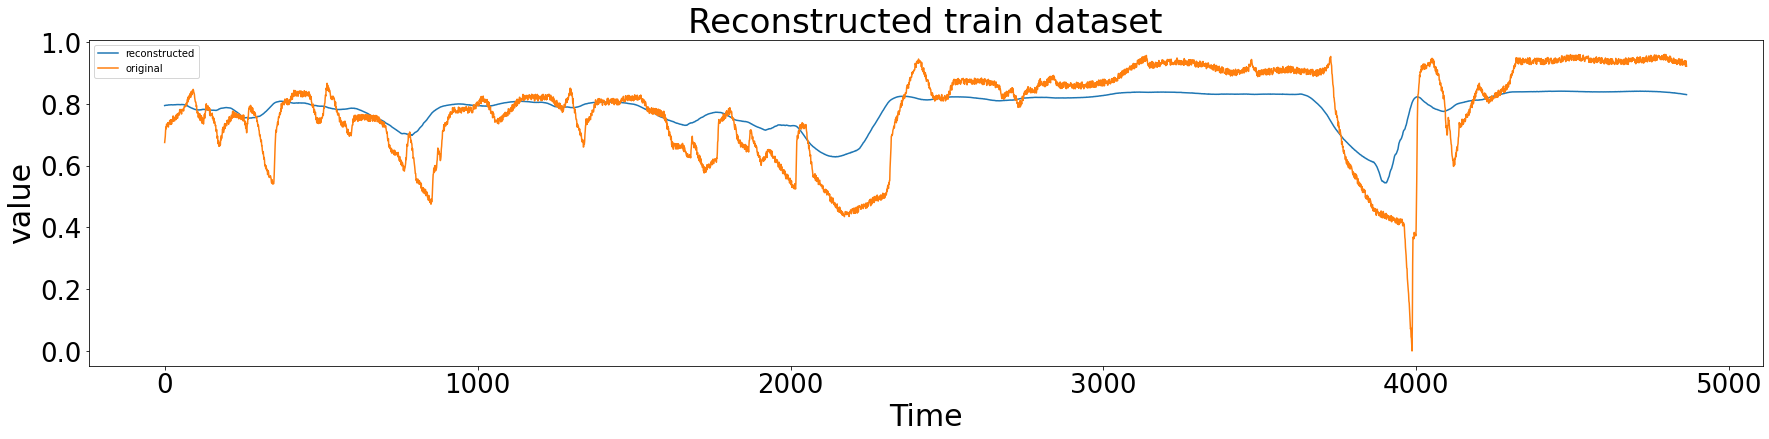

In [98]:
fig = plt.figure(figsize=(30, 6))
ax = fig.add_subplot(111)

plt.plot(x_values_train, reconstructed_train, label='reconstructed')
plt.plot(x_values_train, signal_train, label='original')


plt.title('Reconstructed train dataset', size=34)
plt.ylabel('value', size=30)
plt.xlabel('Time', size=30)
plt.xticks(size=26)
plt.yticks(size=26)
plt.legend()
    
plt.show()

In [101]:
x_values_test = np.arange(start=0, stop=len(reconstructed_test), step=1)
signal_test = temperature_data['signal'][5000:5000+len(reconstructed_test)]

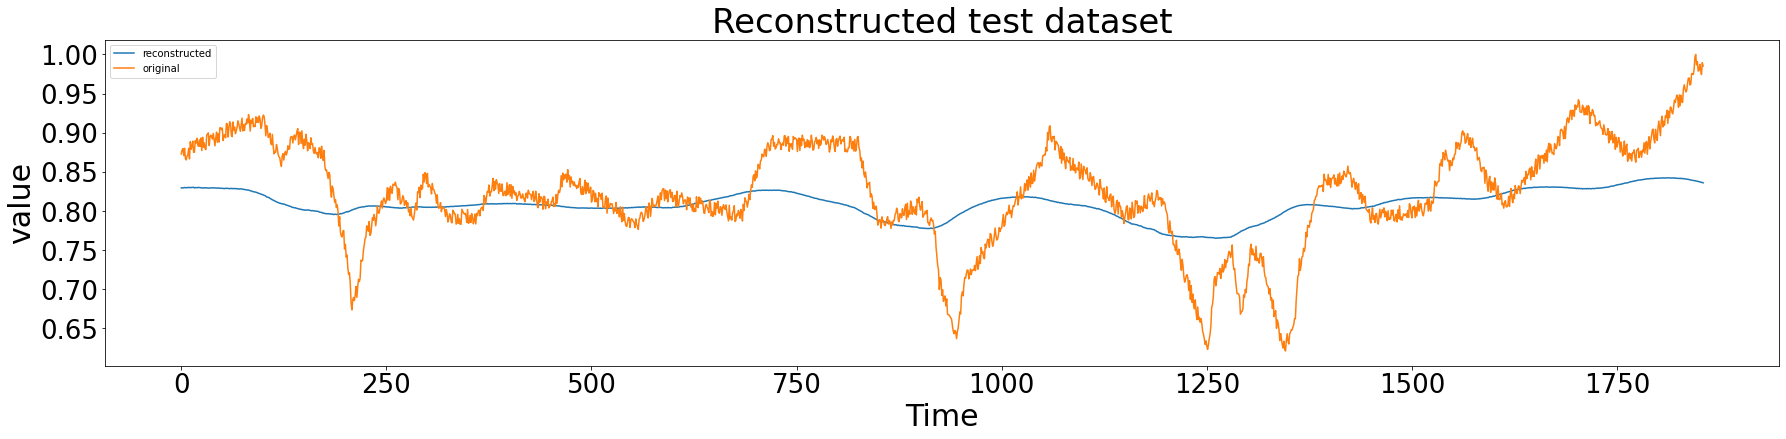

In [102]:
fig = plt.figure(figsize=(30, 6))
ax = fig.add_subplot(111)

plt.plot(x_values_test, reconstructed_test, label='reconstructed')
plt.plot(x_values_test, signal_test, label='original')


plt.title('Reconstructed test dataset', size=34)
plt.ylabel('value', size=30)
plt.xlabel('Time', size=30)
plt.xticks(size=26)
plt.yticks(size=26)
plt.legend()
    
plt.show()

Save reconstructed signal to file

In [103]:
df_train = pd.DataFrame (reconstructed_train, columns = ['reconstructed'])
df_train['timestamp'] = temperature_data_train['timestamp'][:len(reconstructed_train)].values
df_train['signal'] = temperature_data_train['signal'][:len(reconstructed_train)].values
print(df_train.head())
print(df_train.info())
df_train.to_csv('/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/temperature_train_reconstructed.csv', index=False)


   reconstructed   timestamp    signal
0       0.795040  1386018900  0.675424
1       0.795132  1386019200  0.684525
2       0.795568  1386019500  0.695691
3       0.795730  1386019800  0.714638
4       0.796081  1386020100  0.725812
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4864 entries, 0 to 4863
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reconstructed  4864 non-null   float64
 1   timestamp      4864 non-null   int64  
 2   signal         4864 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 114.1 KB
None


In [104]:
print(len(reconstructed_test))

1856


In [105]:
df_test = pd.DataFrame (reconstructed_test, columns = ['reconstructed'])
print(df_test.info())
print(df_test.head())
df_test['timestamp'] = temperature_data_test['timestamp'][:len(reconstructed_test)].values
df_test['signal'] = temperature_data_test['signal'][:len(reconstructed_test)].values
print(df_test.head())
print(df_test.info())
df_test.to_csv('/content/drive/MyDrive/GANAnomalyDetection/count_reconstructed_error/datasets/temperature_test_reconstructed.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1856 entries, 0 to 1855
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reconstructed  1856 non-null   float64
dtypes: float64(1)
memory usage: 14.6 KB
None
   reconstructed
0       0.829503
1       0.829457
2       0.829515
3       0.829576
4       0.830039
   reconstructed   timestamp    signal
0       0.829503  1387518900  0.872812
1       0.829457  1387519200  0.878082
2       0.829515  1387519500  0.879614
3       0.829576  1387519800  0.870780
4       0.830039  1387520100  0.880160
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1856 entries, 0 to 1855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reconstructed  1856 non-null   float64
 1   timestamp      1856 non-null   int64  
 2   signal         1856 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 43.6 KB
Non